# Stage 2.3 — EDA relationships, correlations, and artifacts (Blocks E/F/G)


This notebook continues Stage 2 from sanitized + quality-labeled tables and focuses on directional relationships, grouped correlation screening, targeted validation plots, artifact review, and synthesized findings.


In [1]:
from __future__ import annotations

from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from garmin_analytics.eda import add_derived_features, build_eda_frames, load_daily_sanitized, load_quality
from garmin_analytics.eda.plots_common import maybe_savefig, repo_root

In [2]:
SAVE_FIGS: bool = False
DPI: int = 150
FIG_FMT: str = 'png'

ROOT = repo_root(Path.cwd())
DAILY_PATH = ROOT / 'data/processed/daily_sanitized.parquet'
QUALITY_PATH = ROOT / 'data/processed/daily_quality.parquet'
SUSPICIOUS_PATH = ROOT / 'reports/suspicious_days.csv'
SUSPICIOUS_ARTIFACTS_PATH = ROOT / 'reports/suspicious_days_artifacts.csv'
FIG_DIR = ROOT / 'reports/figures/distributions'

print('Repo root:', ROOT)
print('Daily input:', DAILY_PATH)
print('Quality input:', QUALITY_PATH)
print('Suspicious input:', SUSPICIOUS_PATH)
print('Suspicious artifacts input:', SUSPICIOUS_ARTIFACTS_PATH)


Repo root: /Users/abatrakov/Documents/FUN/wearable-analytics
Daily input: /Users/abatrakov/Documents/FUN/wearable-analytics/data/processed/daily_sanitized.parquet
Quality input: /Users/abatrakov/Documents/FUN/wearable-analytics/data/processed/daily_quality.parquet
Suspicious input: /Users/abatrakov/Documents/FUN/wearable-analytics/reports/suspicious_days.csv
Suspicious artifacts input: /Users/abatrakov/Documents/FUN/wearable-analytics/reports/suspicious_days_artifacts.csv


In [3]:
daily_df = load_daily_sanitized(DAILY_PATH)
quality_df = load_quality(QUALITY_PATH)
frames = build_eda_frames(daily_df, quality_df)


def _sanitize_stress_level_range_base(frame: pd.DataFrame, *, lo: float = 0.0, hi: float = 100.0) -> pd.DataFrame:
    """Notebook-global cleanup for stress-level sentinels (e.g., -2)."""
    out = frame.copy()
    for col in out.columns:
        if ('averageStressLevel' in str(col)) or ('avgSleepStress' in str(col)):
            s = pd.to_numeric(out[col], errors='coerce')
            out[col] = s.where((s >= lo) & (s <= hi))
    return out


df_all = _sanitize_stress_level_range_base(add_derived_features(frames['df_all']))
df_strict = _sanitize_stress_level_range_base(add_derived_features(frames['df_strict']))
df_sleep = _sanitize_stress_level_range_base(add_derived_features(frames['df_sleep']))

suspicious_days = pd.read_csv(SUSPICIOUS_PATH) if SUSPICIOUS_PATH.exists() else pd.DataFrame()
suspicious_days_artifacts = pd.read_csv(SUSPICIOUS_ARTIFACTS_PATH) if SUSPICIOUS_ARTIFACTS_PATH.exists() else pd.DataFrame()

pd.DataFrame([
    {'slice': 'df_all', 'rows': len(df_all), 'date_min': pd.to_datetime(df_all['calendarDate']).min(), 'date_max': pd.to_datetime(df_all['calendarDate']).max()},
    {'slice': 'df_strict', 'rows': len(df_strict), 'date_min': pd.to_datetime(df_strict['calendarDate']).min(), 'date_max': pd.to_datetime(df_strict['calendarDate']).max()},
    {'slice': 'df_sleep', 'rows': len(df_sleep), 'date_min': pd.to_datetime(df_sleep['calendarDate']).min(), 'date_max': pd.to_datetime(df_sleep['calendarDate']).max()},
])



slice  rows   date_min   date_max
0     df_all   580 2023-05-26 2026-02-05
1  df_strict   525 2023-05-26 2026-02-05
2   df_sleep   474 2023-05-27 2026-02-05

In [4]:
def _sleep_score_bucket_garmin(score):
    if pd.isna(score):
        return 'unknown'
    score = float(score)
    if score < 60:
        return 'poor'
    if score < 80:
        return 'fair'
    if score < 90:
        return 'good'
    return 'excellent'


def _ensure_step_length(frame: pd.DataFrame, *, min_steps: int = 1000) -> pd.DataFrame:
    out = frame.copy()
    if {'totalSteps', 'totalDistanceMeters'}.issubset(out.columns):
        steps = pd.to_numeric(out['totalSteps'], errors='coerce')
        dist = pd.to_numeric(out['totalDistanceMeters'], errors='coerce')
        out['step_length_m'] = np.where(steps >= min_steps, dist / steps, np.nan)
    return out


def _ensure_activity_duration_hours(frame: pd.DataFrame) -> pd.DataFrame:
    out = frame.copy()
    if 'activeSeconds' in out.columns and 'active_hours' not in out.columns:
        out['active_hours'] = pd.to_numeric(out['activeSeconds'], errors='coerce') / 3600.0
    if 'highlyActiveSeconds' in out.columns:
        out['highly_active_hours'] = pd.to_numeric(out['highlyActiveSeconds'], errors='coerce') / 3600.0
    return out


def _ensure_bb_net(frame: pd.DataFrame) -> pd.DataFrame:
    out = frame.copy()
    charged_cols = [c for c in ['bodyBattery_chargedValue', 'bodyBatteryChargedValue'] if c in out.columns]
    drained_cols = [c for c in ['bodyBattery_drainedValue', 'bodyBatteryDrainedValue'] if c in out.columns]
    if charged_cols and drained_cols:
        out['bb_net_balance'] = (
            pd.to_numeric(out[charged_cols[0]], errors='coerce')
            - pd.to_numeric(out[drained_cols[0]], errors='coerce')
        )
    return out


df_strict_d = _ensure_bb_net(_ensure_activity_duration_hours(_ensure_step_length(df_strict, min_steps=1000)))
df_sleep_d = _ensure_bb_net(_ensure_activity_duration_hours(_ensure_step_length(df_sleep, min_steps=1000)))
if 'sleepOverallScore' in df_sleep_d.columns:
    df_sleep_d['sleep_quality_bucket_garmin'] = pd.to_numeric(df_sleep_d['sleepOverallScore'], errors='coerce').apply(_sleep_score_bucket_garmin)

metric_roster = pd.DataFrame([
    {'group': 'activity', 'metric': 'totalSteps', 'slice': 'df_strict', 'role': 'distribution+relationship', 'priority': 'core'},
    {'group': 'activity', 'metric': 'step_length_m', 'slice': 'df_strict_d', 'role': 'distribution+relationship', 'priority': 'core'},
    {'group': 'activity', 'metric': 'active_hours', 'slice': 'df_strict_d', 'role': 'distribution+relationship', 'priority': 'core'},
    {'group': 'activity', 'metric': 'highly_active_hours', 'slice': 'df_strict_d', 'role': 'distribution+relationship', 'priority': 'core'},
    {'group': 'activity', 'metric': 'floorsAscendedInMeters', 'slice': 'df_strict', 'role': 'distribution', 'priority': 'supporting'},
    {'group': 'stress', 'metric': 'allDayStress_TOTAL_averageStressLevel', 'slice': 'df_strict', 'role': 'distribution+relationship', 'priority': 'core'},
    {'group': 'stress', 'metric': 'allDayStress_AWAKE_averageStressLevel', 'slice': 'df_strict', 'role': 'distribution+relationship', 'priority': 'core'},
    {'group': 'stress', 'metric': 'allDayStress_ASLEEP_averageStressLevel', 'slice': 'df_sleep', 'role': 'distribution+relationship', 'priority': 'core'},
    {'group': 'stress', 'metric': 'stress_hours', 'slice': 'df_strict', 'role': 'distribution+artifact-diagnostic', 'priority': 'supporting'},
    {'group': 'heart', 'metric': 'restingHeartRate', 'slice': 'df_strict', 'role': 'distribution+relationship', 'priority': 'core'},
    {'group': 'heart', 'metric': 'minHeartRate', 'slice': 'df_strict', 'role': 'distribution', 'priority': 'supporting'},
    {'group': 'heart', 'metric': 'maxHeartRate', 'slice': 'df_strict', 'role': 'distribution', 'priority': 'supporting'},
    {'group': 'body_battery', 'metric': 'bodyBatteryHighest', 'slice': 'df_strict', 'role': 'distribution+relationship', 'priority': 'core'},
    {'group': 'body_battery', 'metric': 'bodyBatteryLowest', 'slice': 'df_strict', 'role': 'distribution+relationship', 'priority': 'core'},
    {'group': 'body_battery', 'metric': 'bodyBattery_chargedValue', 'slice': 'df_strict', 'role': 'distribution+relationship', 'priority': 'core'},
    {'group': 'body_battery', 'metric': 'bodyBattery_drainedValue', 'slice': 'df_strict', 'role': 'distribution+relationship', 'priority': 'core'},
    {'group': 'body_battery', 'metric': 'bb_net_balance', 'slice': 'df_strict_d', 'role': 'distribution+relationship', 'priority': 'core'},
    {'group': 'sleep', 'metric': 'sleep_total_hours', 'slice': 'df_sleep_d', 'role': 'distribution+relationship', 'priority': 'core'},
    {'group': 'sleep', 'metric': 'sleepOverallScore', 'slice': 'df_sleep', 'role': 'distribution+relationship', 'priority': 'core'},
    {'group': 'sleep', 'metric': 'sleepQualityScore', 'slice': 'df_sleep', 'role': 'distribution', 'priority': 'supporting'},
    {'group': 'sleep', 'metric': 'sleepDurationScore', 'slice': 'df_sleep', 'role': 'distribution', 'priority': 'supporting'},
    {'group': 'sleep', 'metric': 'sleepRecoveryScore', 'slice': 'df_sleep', 'role': 'distribution+relationship', 'priority': 'core'},
    {'group': 'sleep', 'metric': 'avgSleepStress', 'slice': 'df_sleep', 'role': 'distribution+relationship', 'priority': 'core'},
    {'group': 'sleep', 'metric': 'averageRespiration', 'slice': 'df_sleep', 'role': 'distribution', 'priority': 'supporting'},
    {'group': 'sleep', 'metric': 'lowestRespiration', 'slice': 'df_sleep', 'role': 'distribution', 'priority': 'supporting'},
    {'group': 'sleep', 'metric': 'highestRespiration', 'slice': 'df_sleep', 'role': 'distribution', 'priority': 'supporting'},
    {'group': 'sleep', 'metric': 'averageSpo2Value / lowestSpo2Value', 'slice': 'df_sleep', 'role': 'distribution+relationship', 'priority': 'supporting'},
    {'group': 'artifact_diagnostic', 'metric': 'stressTotalDurationSeconds', 'slice': 'df_all', 'role': 'artifact-diagnostic', 'priority': 'core'},
    {'group': 'artifact_diagnostic', 'metric': 'durationInMilliseconds', 'slice': 'df_all', 'role': 'artifact-diagnostic', 'priority': 'core'},
    {'group': 'artifact_diagnostic', 'metric': 'has_* flags + corrupted_stress_only_day', 'slice': 'df_all', 'role': 'artifact-diagnostic', 'priority': 'core'},
])

metric_roster


group                                   metric        slice  \
0              activity                               totalSteps    df_strict   
1              activity                            step_length_m  df_strict_d   
2              activity                             active_hours  df_strict_d   
3              activity                      highly_active_hours  df_strict_d   
4              activity                   floorsAscendedInMeters    df_strict   
5                stress    allDayStress_TOTAL_averageStressLevel    df_strict   
6                stress    allDayStress_AWAKE_averageStressLevel    df_strict   
7                stress   allDayStress_ASLEEP_averageStressLevel     df_sleep   
8                stress                             stress_hours    df_strict   
9                 heart                         restingHeartRate    df_strict   
10                heart                             minHeartRate    df_strict   
11                heart                             maxHeartRate    df_strict   
12         body_battery                       bodyBatteryHighest    df_strict   
13         body_battery                        bodyBatteryLowest    df_strict   
14         body_battery                 bodyBattery_chargedValue    df_strict   
15         body_battery                 bodyBattery_drainedValue    df_strict   
16         body_battery                           bb_net_balance  df_strict_d   
17                sleep                        sleep_total_hours   df_sleep_d   
18                sleep                        sleepOverallScore     df_sleep   
19                sleep                        sleepQualityScore     df_sleep   
20                sleep                       sleepDurationScore     df_sleep   
21                sleep                       sleepRecoveryScore     df_sleep   
22                sleep                           avgSleepStress     df_sleep   
23                sleep                       averageRespiration     df_sleep   
24                sleep                        lowestRespiration     df_sleep   
25                sleep                       highestRespiration     df_sleep   
26                sleep       averageSpo2Value / lowestSpo2Value     df_sleep   
27  artifact_diagnostic               stressTotalDurationSeconds       df_all   
28  artifact_diagnostic                   durationInMilliseconds       df_all   
29  artifact_diagnostic  has_* flags + corrupted_stress_only_day       df_all   

                                role    priority  
0          distribution+relationship        core  
1          distribution+relationship        core  
2          distribution+relationship        core  
3          distribution+relationship        core  
4                       distribution  supporting  
5          distribution+relationship        core  
6          distribution+relationship        core  
7          distribution+relationship        core  
8   distribution+artifact-diagnostic  supporting  
9          distribution+relationship        core  
10                      distribution  supporting  
11                      distribution  supporting  
12         distribution+relationship        core  
13         distribution+relationship        core  
14         distribution+relationship        core  
15         distribution+relationship        core  
16         distribution+relationship        core  
17         distribution+relationship        core  
18         distribution+relationship        core  
19                      distribution  supporting  
20                      distribution  supporting  
21         distribution+relationship        core  
22         distribution+relationship        core  
23                      distribution  supporting  
24                      distribution  supporting  
25                      distribution  supporting  
26         distribution+relationship  supporting  
27               artifact-diagnostic        core  
28               artifact-d

## 1. Block E — Relationships / interactions

Question: **Which metrics move together, and which patterns are strong enough to become hypotheses?**

Planned high-priority relationship blocks:
- Sleep -> next-day outcomes (Body Battery / stress / optional steps)
- Stress <-> sleep
- Activity <-> sleep
- Body Battery dynamics <-> sleep / stress
- Supporting: heart <-> sleep / stress

Implementation notes:
- prefer curated scatter / hexbin / binned trend views over giant correlation dumps
- label same-day vs next-day alignment explicitly


### 1.1 Relationship helpers and alignment setup

Relationship plots use compact scatter + **quantile-bin summaries** (median/mean) to reduce over-interpretation from noisy clouds.

**Alignment conventions (important):**
- **Same-day (`D -> D`)**: `sleep(D)` and daytime metrics stored on the same `calendarDate` row (sleep happened at the start of that day, then daytime activity/stress follows).
- **Day -> next-night (`D -> D+1`)**: daytime metrics on day `D` aligned to **next sleep row** (`sleep(D+1)`) to test hypotheses like `day stress -> next-night sleep quality`.
- Avoid interpreting `sleep(D) -> daytime(D+1)` as a default causal direction here; it is possible to test, but not the first-priority question for this dataset narrative.


In [15]:
def _safe_corr(x: pd.Series, y: pd.Series, *, method: str = 'pearson') -> float | None:
    tmp = pd.concat([pd.to_numeric(x, errors='coerce'), pd.to_numeric(y, errors='coerce')], axis=1).dropna()
    if len(tmp) < 3:
        return None
    return float(tmp.iloc[:, 0].corr(tmp.iloc[:, 1], method=method))


def _ensure_sleep_stage_hours(frame: pd.DataFrame) -> pd.DataFrame:
    out = frame.copy()
    stage_map = {
        'deepSleepSeconds': 'deepSleepHours',
        'lightSleepSeconds': 'lightSleepHours',
        'remSleepSeconds': 'remSleepHours',
        'awakeSleepSeconds': 'awakeSleepHours',
        'unmeasurableSeconds': 'unmeasurableSleepHours',
    }
    for sec_col, hr_col in stage_map.items():
        if sec_col in out.columns and hr_col not in out.columns:
            out[hr_col] = pd.to_numeric(out[sec_col], errors='coerce') / 3600.0
    return out


def _row_garmin_offset_hours(frame: pd.DataFrame) -> pd.Series:
    out = pd.Series(np.nan, index=frame.index, dtype='float64')
    for gmt_col, local_col in [('wellnessStartTimeGmt', 'wellnessStartTimeLocal'), ('wellnessEndTimeGmt', 'wellnessEndTimeLocal')]:
        if gmt_col in frame.columns and local_col in frame.columns:
            gmt_ts = pd.to_datetime(frame[gmt_col], errors='coerce')
            local_ts = pd.to_datetime(frame[local_col], errors='coerce')
            delta_h = (local_ts - gmt_ts).dt.total_seconds() / 3600.0
            out = out.where(~out.isna(), delta_h)
    return out


def _ensure_sleep_local_time_features(frame: pd.DataFrame) -> pd.DataFrame:
    out = frame.copy()
    if 'sleepStartTimestampGMT' in out.columns and 'sleep_start_hour_local' not in out.columns:
        sleep_start_utc = pd.to_datetime(pd.to_numeric(out['sleepStartTimestampGMT'], errors='coerce'), unit='s', utc=True, errors='coerce')
        offset_h = _row_garmin_offset_hours(out)
        # Fallback to local machine timezone conversion only if Garmin per-row offset is unavailable.
        local_dt = sleep_start_utc.copy()
        mask = offset_h.notna() & sleep_start_utc.notna()
        if mask.any():
            local_dt.loc[mask] = sleep_start_utc.loc[mask] + pd.to_timedelta(offset_h.loc[mask], unit='h')
        out['sleep_start_hour_local'] = (
            local_dt.dt.hour.astype('float64')
            + local_dt.dt.minute.astype('float64') / 60.0
            + local_dt.dt.second.astype('float64') / 3600.0
        )
    return out




def _ensure_sleep_start_hour_wrapped(
    frame: pd.DataFrame,
    *,
    src_col: str = 'sleep_start_hour_local',
    dst_col: str = 'sleep_start_hour_local_wrapped',
    wrap_at: float = 18.0,
) -> pd.DataFrame:
    out = frame.copy()
    if src_col not in out.columns:
        return out
    h = pd.to_numeric(out[src_col], errors='coerce')
    out[dst_col] = np.where(h >= wrap_at, h - 24.0, h)
    return out


def _prepare_day_to_next_sleep(day_frame: pd.DataFrame, sleep_frame: pd.DataFrame, next_sleep_cols: list[str]) -> pd.DataFrame:
    day = day_frame.copy()
    day['calendarDate'] = pd.to_datetime(day['calendarDate'], errors='coerce').dt.normalize()
    day = day.dropna(subset=['calendarDate'])

    sleep = sleep_frame.copy()
    sleep['calendarDate'] = pd.to_datetime(sleep['calendarDate'], errors='coerce').dt.normalize()
    sleep = sleep.dropna(subset=['calendarDate'])
    keep_sleep = ['calendarDate'] + [c for c in next_sleep_cols if c in sleep.columns]
    sleep = sleep[keep_sleep].copy()
    sleep['day_date'] = sleep['calendarDate'] - pd.Timedelta(days=1)
    rename_map = {c: f'nextsleep_{c}' for c in sleep.columns if c not in {'calendarDate', 'day_date'}}
    sleep = sleep.rename(columns=rename_map)

    merged = day.merge(sleep.drop(columns=['calendarDate']), left_on='calendarDate', right_on='day_date', how='left')
    return merged


def _quantile_binned_summary(df: pd.DataFrame, xcol: str, ycol: str, q: int = 10) -> pd.DataFrame:
    tmp = df[[xcol, ycol]].copy()
    tmp[xcol] = pd.to_numeric(tmp[xcol], errors='coerce')
    tmp[ycol] = pd.to_numeric(tmp[ycol], errors='coerce')
    tmp = tmp.dropna()
    if len(tmp) < max(15, q * 2):
        return pd.DataFrame()
    try:
        q_eff = int(min(q, max(2, tmp[xcol].nunique())))
        bins = pd.qcut(tmp[xcol], q=q_eff, duplicates='drop')
    except Exception:
        return pd.DataFrame()

    g = tmp.groupby(bins, observed=True)
    out = pd.DataFrame({
        'x_median': g[xcol].median(),
        'y_median': g[ycol].median(),
        'y_mean': g[ycol].mean(),
        'y_q25': g[ycol].quantile(0.25),
        'y_q75': g[ycol].quantile(0.75),
        'n': g[ycol].size(),
    }).reset_index(drop=True)
    return out


def _format_clock_axis(ax, *, axis: str = 'x') -> None:
    if axis not in {'x', 'y'}:
        return
    lo, hi = (ax.get_xlim() if axis == 'x' else ax.get_ylim())
    lo_i = int(np.floor(lo))
    hi_i = int(np.ceil(hi))
    span = max(1, hi_i - lo_i)
    step = 1 if span <= 14 else 2
    ticks = np.arange(lo_i, hi_i + 1, step)
    labels = [f"{int(t % 24):02d}" for t in ticks]
    if axis == 'x':
        ax.set_xticks(ticks)
        ax.set_xticklabels(labels)
    else:
        ax.set_yticks(ticks)
        ax.set_yticklabels(labels)


def plot_relationship(
    frame: pd.DataFrame,
    xcol: str,
    ycol: str,
    *,
    title: str,
    xlabel: str | None = None,
    ylabel: str | None = None,
    fig_name: str | None = None,
    max_points: int = 1200,
    clock_axis_x: bool = False,
    clock_axis_y: bool = False,
):
    if xcol not in frame.columns or ycol not in frame.columns:
        print(f'Skip relationship: missing {xcol} or {ycol}')
        return
    tmp = frame[[xcol, ycol]].copy()
    tmp[xcol] = pd.to_numeric(tmp[xcol], errors='coerce')
    tmp[ycol] = pd.to_numeric(tmp[ycol], errors='coerce')
    tmp = tmp.dropna()
    if tmp.empty:
        print(f'Skip relationship: no data for {xcol} vs {ycol}')
        return

    tmp_plot = tmp.sample(max_points, random_state=42) if len(tmp) > max_points else tmp
    binned = _quantile_binned_summary(tmp, xcol, ycol, q=10)
    corr = _safe_corr(tmp[xcol], tmp[ycol], method='pearson')

    fig, axes = plt.subplots(1, 2, figsize=(13, 4), gridspec_kw={'width_ratios': [3, 2]})
    ax_sc, ax_bin = axes

    ax_sc.scatter(tmp_plot[xcol], tmp_plot[ycol], s=16, alpha=0.22, edgecolors='none', color='#1f77b4')
    ax_sc.set_title(title)
    ax_sc.set_xlabel(xlabel or xcol)
    ax_sc.set_ylabel(ylabel or ycol)
    ax_sc.grid(alpha=0.2)
    if corr is not None and np.isfinite(corr):
        ax_sc.text(
            0.02, 0.98, f'Pearson r = {corr:.2f} (n={len(tmp)})', transform=ax_sc.transAxes,
            ha='left', va='top', fontsize=9,
            bbox=dict(boxstyle='round,pad=0.25', facecolor='white', alpha=0.75, edgecolor='none'),
        )

    if not binned.empty:
        b = binned.sort_values('x_median')
        ax_bin.fill_between(b['x_median'], b['y_q25'], b['y_q75'], color='#d62728', alpha=0.15, label='binned IQR (q25-q75)')
        ax_bin.plot(b['x_median'], b['y_median'], marker='o', lw=1.8, color='#d62728', label='binned median')
        ax_bin.scatter(b['x_median'], b['y_mean'], marker='x', s=36, color='#9467bd', label='binned mean')
        for _, r in b.iterrows():
            ax_bin.annotate(str(int(r['n'])), (r['x_median'], r['y_median']), textcoords='offset points', xytext=(0, 5), ha='center', fontsize=7, color='#444')
        ax_bin.legend(loc='best', fontsize=8)
    else:
        ax_bin.text(0.5, 0.5, 'Binned summary unavailable', ha='center', va='center', transform=ax_bin.transAxes)
    ax_bin.set_title('quantile-bin summary')
    ax_bin.set_xlabel(xlabel or xcol)
    ax_bin.set_ylabel(ylabel or ycol)
    ax_bin.grid(alpha=0.2)

    if clock_axis_x:
        _format_clock_axis(ax_sc, axis='x')
        _format_clock_axis(ax_bin, axis='x')
    if clock_axis_y:
        _format_clock_axis(ax_sc, axis='y')
        _format_clock_axis(ax_bin, axis='y')

    fig.tight_layout()
    if fig_name is not None:
        maybe_savefig(fig, fig_name, save_figs=SAVE_FIGS, fig_dir=FIG_DIR, dpi=DPI, fmt=FIG_FMT)
    plt.show()
    plt.close(fig)


def _pairwise_corr_block(frame: pd.DataFrame, row_cols: list[str], col_cols: list[str], *, method: str = 'spearman'):
    rows = [c for c in row_cols if c in frame.columns]
    cols = [c for c in col_cols if c in frame.columns]
    if not rows or not cols:
        return pd.DataFrame(), pd.DataFrame()
    corr = pd.DataFrame(index=rows, columns=cols, dtype='float64')
    nobs = pd.DataFrame(index=rows, columns=cols, dtype='float64')
    for r in rows:
        for c in cols:
            x = pd.to_numeric(frame[r], errors='coerce')
            y = pd.to_numeric(frame[c], errors='coerce')
            tmp = pd.concat({'x': x, 'y': y}, axis=1).dropna()
            nobs.loc[r, c] = len(tmp)
            if len(tmp) >= 3:
                corr.loc[r, c] = tmp['x'].corr(tmp['y'], method=method)
            else:
                corr.loc[r, c] = np.nan
    return corr, nobs


def plot_corr_block(
    frame: pd.DataFrame,
    row_cols: list[str],
    col_cols: list[str],
    *,
    title: str,
    method: str = 'spearman',
    fig_name: str | None = None,
    min_n: int = 40,
    mask_low_n: bool = True,
):
    corr, nobs = _pairwise_corr_block(frame, row_cols, col_cols, method=method)
    if corr.empty:
        print(f'Skip corr block: {title} (missing columns)')
        return

    fig, axes = plt.subplots(1, 2, figsize=(max(10, 0.8 * len(corr.columns) + 4), max(4.5, 0.45 * len(corr.index) + 2)), gridspec_kw={'width_ratios': [4, 1.3]})
    ax_hm, ax_n = axes
    arr_raw = corr.to_numpy(dtype=float)
    n_arr = nobs.to_numpy(dtype=float)
    arr = np.where(n_arr >= float(min_n), arr_raw, np.nan) if mask_low_n else arr_raw

    base_cmap = plt.cm.get_cmap('coolwarm')
    # Matplotlib compatibility: some versions do not expose Colormap.copy().
    if hasattr(base_cmap, 'copy'):
        cmap = base_cmap.copy()
    else:
        cmap = plt.cm.get_cmap('coolwarm', 256)
    cmap.set_bad(color='#d9d9d9')
    im = ax_hm.imshow(arr, aspect='auto', cmap=cmap, vmin=-1, vmax=1)

    n_tag = f', n≥{min_n}' if mask_low_n else ''
    ax_hm.set_title(f'{title} ({method}{n_tag})')
    ax_hm.set_xticks(range(len(corr.columns)))
    ax_hm.set_xticklabels(corr.columns, rotation=45, ha='right', fontsize=8)
    ax_hm.set_yticks(range(len(corr.index)))
    ax_hm.set_yticklabels(corr.index, fontsize=8)
    for r in range(arr.shape[0]):
        for c in range(arr.shape[1]):
            val = arr[r, c]
            if np.isfinite(val):
                ax_hm.text(c, r, f'{val:.2f}', ha='center', va='center', fontsize=7, color='white' if abs(val) > 0.5 else 'black')
            elif mask_low_n and np.isfinite(n_arr[r, c]) and n_arr[r, c] < min_n:
                ax_hm.text(c, r, '·', ha='center', va='center', fontsize=8, color='#555')

    cbar = fig.colorbar(im, ax=ax_hm, fraction=0.046, pad=0.04)
    cbar.ax.set_ylabel('corr', rotation=90)

    # right panel: minimum/median pairwise n per row to judge reliability
    n_summary = pd.DataFrame({
        'n_min': nobs.min(axis=1, skipna=True),
        'n_med': nobs.median(axis=1, skipna=True),
    })
    y = np.arange(len(n_summary))
    ax_n.barh(y - 0.15, n_summary['n_min'].fillna(0), height=0.28, label='n_min', color='#8da0cb')
    ax_n.barh(y + 0.15, n_summary['n_med'].fillna(0), height=0.28, label='n_med', color='#66c2a5')
    if mask_low_n:
        ax_n.axvline(min_n, ls='--', lw=1.0, color='#444', label=f'n threshold ({min_n})')
    ax_n.set_yticks(y)
    ax_n.set_yticklabels([])
    ax_n.set_title('pairwise n')
    ax_n.grid(axis='x', alpha=0.2)
    ax_n.legend(fontsize=7, loc='best')

    fig.tight_layout()
    if fig_name is not None:
        maybe_savefig(fig, fig_name, save_figs=SAVE_FIGS, fig_dir=FIG_DIR, dpi=DPI, fmt=FIG_FMT)
    plt.show()
    plt.close(fig)


def _ensure_stress_context_features(frame: pd.DataFrame, context: str, *, prefix: str) -> pd.DataFrame:
    """Create readable aliases + hours/shares for Garmin allDayStress_<CONTEXT> fields."""
    out = frame.copy()
    base = f'allDayStress_{context}_'

    avg_col = base + 'averageStressLevel'
    if avg_col in out.columns:
        out[f'{prefix}AverageStressLevel'] = pd.to_numeric(out[avg_col], errors='coerce')

    duration_alias = {
        'activityDuration': f'{prefix}ActivityHours',
        'lowDuration': f'{prefix}LowStressHours',
        'mediumDuration': f'{prefix}MediumStressHours',
        'highDuration': f'{prefix}HighStressHours',
        'restDuration': f'{prefix}RestHours',
        'uncategorizedDuration': f'{prefix}UncatHours',
        'totalDuration': f'{prefix}MeasuredHours',
    }
    for raw_suffix, alias in duration_alias.items():
        raw_col = base + raw_suffix
        if raw_col in out.columns:
            out[alias] = pd.to_numeric(out[raw_col], errors='coerce') / 3600.0

    total_col = f'{prefix}MeasuredHours'
    if total_col in out.columns:
        total = pd.to_numeric(out[total_col], errors='coerce')
        for stem in ['Activity', 'LowStress', 'MediumStress', 'HighStress', 'Rest', 'Uncat']:
            hcol = f'{prefix}{stem}Hours'
            scol = f'{prefix}{stem}Share'
            if hcol in out.columns:
                numer = pd.to_numeric(out[hcol], errors='coerce')
                out[scol] = np.nan
                mask = total.notna() & numer.notna() & (total > 0)
                if mask.any():
                    out.loc[mask, scol] = numer.loc[mask] / total.loc[mask]
    return out


def _ensure_bodybattery_aliases(frame: pd.DataFrame) -> pd.DataFrame:
    out = frame.copy()
    if 'bodyBattery_chargedValue' in out.columns and 'bodyBatteryCharged' not in out.columns:
        out['bodyBatteryCharged'] = pd.to_numeric(out['bodyBattery_chargedValue'], errors='coerce')
    if 'bodyBattery_drainedValue' in out.columns and 'bodyBatteryDrained' not in out.columns:
        out['bodyBatteryDrained'] = pd.to_numeric(out['bodyBattery_drainedValue'], errors='coerce')
    if 'bodyBatteryCharged' in out.columns and 'bodyBatteryDrained' in out.columns and 'bodyBatteryNetBalance' not in out.columns:
        out['bodyBatteryNetBalance'] = pd.to_numeric(out['bodyBatteryCharged'], errors='coerce') - pd.to_numeric(out['bodyBatteryDrained'], errors='coerce')
    return out


def _ensure_sleep_sensor_aliases(frame: pd.DataFrame) -> pd.DataFrame:
    out = frame.copy()
    # Prefer explicit sleep-summary names if present, otherwise fallback to legacy names.
    if 'sleepSpo2Average' not in out.columns:
        if 'spo2SleepAverageSPO2' in out.columns:
            out['sleepSpo2Average'] = pd.to_numeric(out['spo2SleepAverageSPO2'], errors='coerce')
        elif 'averageSpo2Value' in out.columns:
            out['sleepSpo2Average'] = pd.to_numeric(out['averageSpo2Value'], errors='coerce')
    if 'sleepSpo2Lowest' not in out.columns:
        if 'spo2SleepLowestSPO2' in out.columns:
            out['sleepSpo2Lowest'] = pd.to_numeric(out['spo2SleepLowestSPO2'], errors='coerce')
        elif 'lowestSpo2Value' in out.columns:
            out['sleepSpo2Lowest'] = pd.to_numeric(out['lowestSpo2Value'], errors='coerce')
    if 'sleepSpo2AverageHR' not in out.columns and 'spo2SleepAverageHR' in out.columns:
        out['sleepSpo2AverageHR'] = pd.to_numeric(out['spo2SleepAverageHR'], errors='coerce')

    for raw, alias in [
        ('averageRespiration', 'sleepRespirationAverage'),
        ('lowestRespiration', 'sleepRespirationLowest'),
        ('highestRespiration', 'sleepRespirationHighest'),
    ]:
        if alias not in out.columns and raw in out.columns:
            out[alias] = pd.to_numeric(out[raw], errors='coerce')
    return out


def _sanitize_stress_level_range(frame: pd.DataFrame, *, lo: float = 0.0, hi: float = 100.0) -> pd.DataFrame:
    # Drop sentinel/invalid stress averages outside Garmin scale [0, 100].
    out = frame.copy()
    for col in out.columns:
        if ('averageStressLevel' in str(col)) or ('avgSleepStress' in str(col)):
            s = pd.to_numeric(out[col], errors='coerce')
            out[col] = s.where((s >= lo) & (s <= hi))
    return out


def _safe_display_any(obj):
    try:
        _safe_display(obj)  # defined earlier in notebook (cell 27)
    except Exception:
        print(obj.to_string(index=False) if hasattr(obj, 'to_string') else obj)


def _prepare_e_frames() -> tuple[pd.DataFrame, pd.DataFrame, pd.DataFrame]:
    strict = _ensure_bb_net(_ensure_activity_duration_hours(_ensure_step_length(df_strict, min_steps=1000)))
    sleep = _ensure_bb_net(_ensure_activity_duration_hours(_ensure_step_length(df_sleep, min_steps=1000)))
    strict = _ensure_bodybattery_aliases(strict)
    sleep = _ensure_bodybattery_aliases(sleep)
    strict = _ensure_stress_context_features(strict, 'AWAKE', prefix='awake')
    strict = _ensure_stress_context_features(strict, 'ASLEEP', prefix='sleep')  # may be partially available in strict rows with sleep
    strict = _ensure_stress_context_features(strict, 'TOTAL', prefix='total')
    strict = _sanitize_stress_level_range(strict)
    sleep = _ensure_stress_context_features(sleep, 'AWAKE', prefix='awake')
    sleep = _ensure_stress_context_features(sleep, 'ASLEEP', prefix='sleep')
    sleep = _ensure_stress_context_features(sleep, 'TOTAL', prefix='total')
    sleep = _ensure_sleep_stage_hours(sleep)
    sleep = _ensure_sleep_local_time_features(sleep)
    sleep = _ensure_sleep_start_hour_wrapped(sleep)
    sleep = _ensure_sleep_sensor_aliases(sleep)
    sleep = _sanitize_stress_level_range(sleep)
    if 'sleepOverallScore' in sleep.columns and 'sleep_quality_bucket_garmin' not in sleep.columns:
        sleep['sleep_quality_bucket_garmin'] = pd.to_numeric(sleep['sleepOverallScore'], errors='coerce').apply(_sleep_score_bucket_garmin)

    next_sleep_cols = [
        # sleep core / extended
        'sleep_total_hours', 'sleepOverallScore', 'sleepQualityScore', 'sleepDurationScore', 'sleepRecoveryScore',
        'sleep_start_hour_local', 'sleep_start_hour_local_wrapped', 'avgSleepStress', 'awakeSleepHours', 'deepSleepHours', 'lightSleepHours', 'remSleepHours', 'unmeasurableSleepHours',
        'sleepRespirationAverage', 'sleepRespirationLowest', 'sleepRespirationHighest',
        'sleepSpo2Average', 'sleepSpo2Lowest', 'sleepSpo2AverageHR',
        # ASLEEP stress alias layer
        'sleepAverageStressLevel', 'sleepActivityHours', 'sleepLowStressHours', 'sleepMediumStressHours', 'sleepHighStressHours', 'sleepRestHours', 'sleepUncatHours',
        'sleepActivityShare', 'sleepLowStressShare', 'sleepMediumStressShare', 'sleepHighStressShare', 'sleepRestShare', 'sleepUncatShare',
        # physiology overlap
        'restingHeartRate', 'currentDayRestingHeartRate',
    ]
    day_nextsleep = _prepare_day_to_next_sleep(strict, sleep, next_sleep_cols)
    day_nextsleep = _sanitize_stress_level_range(day_nextsleep)
    return strict, sleep, day_nextsleep


df_strict_e, df_sleep_e, df_day_nextsleep = _prepare_e_frames()






### 1.2 Sleep (morning) -> same-day daytime outcomes (`D -> D`)

These comparisons are time-aligned in the natural within-day order for this dataset: sleep at the start of day `D`, then daytime activity/stress during the same `calendarDate`.


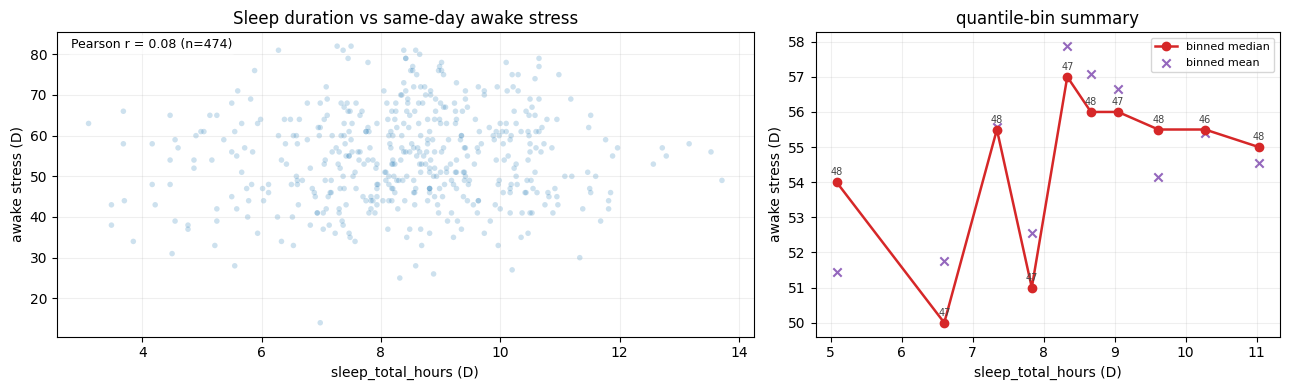

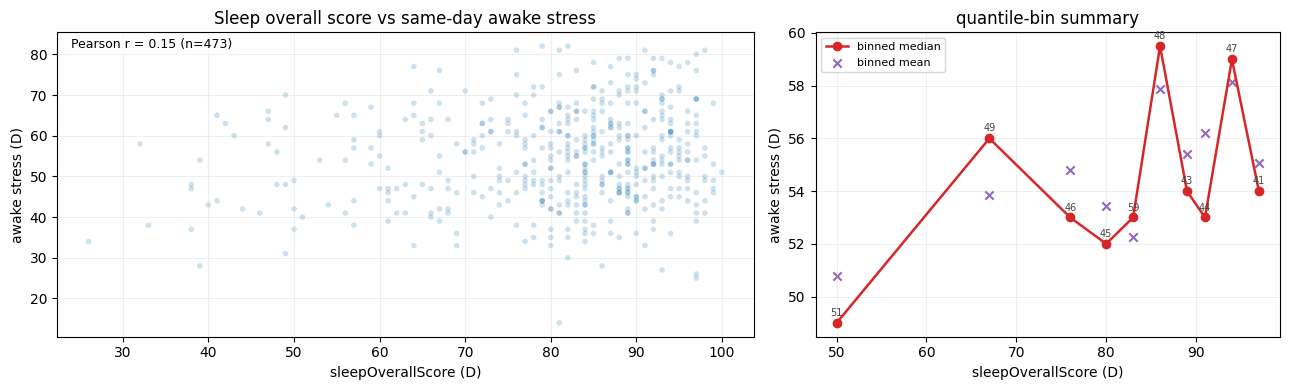

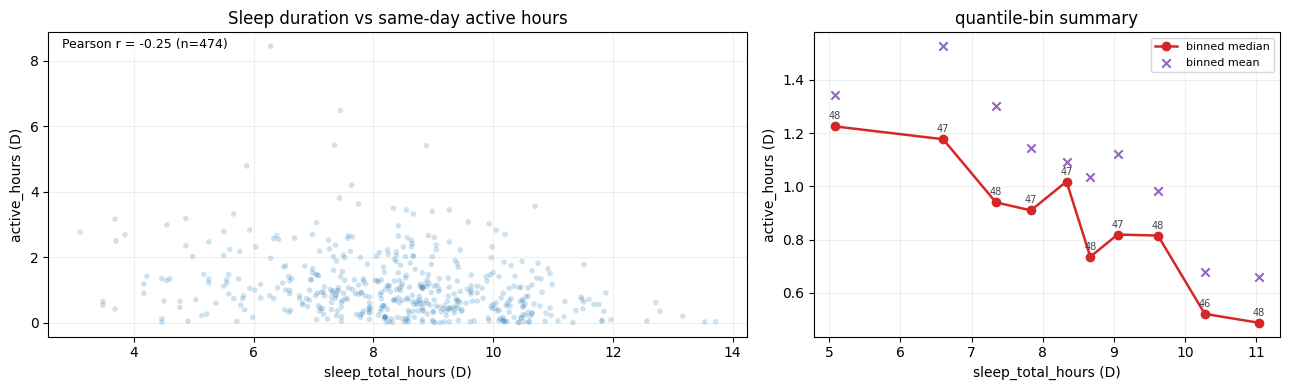

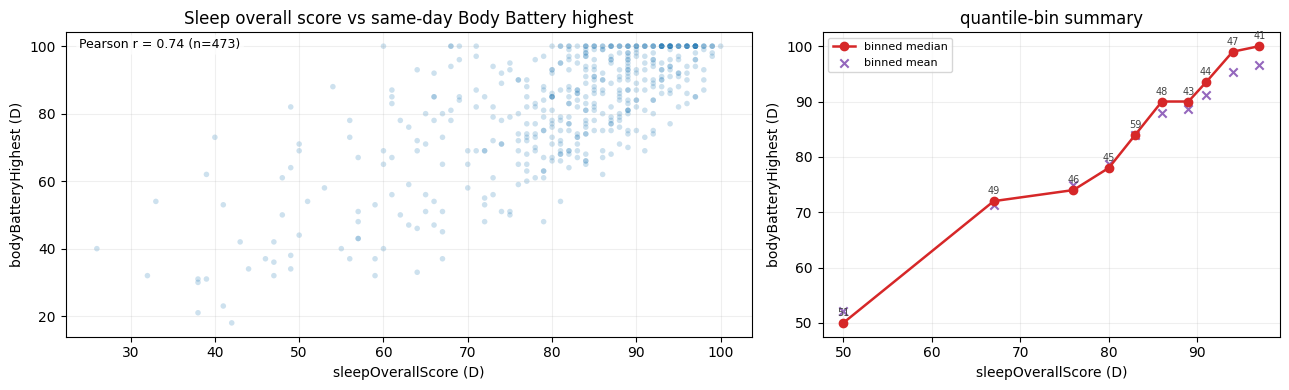

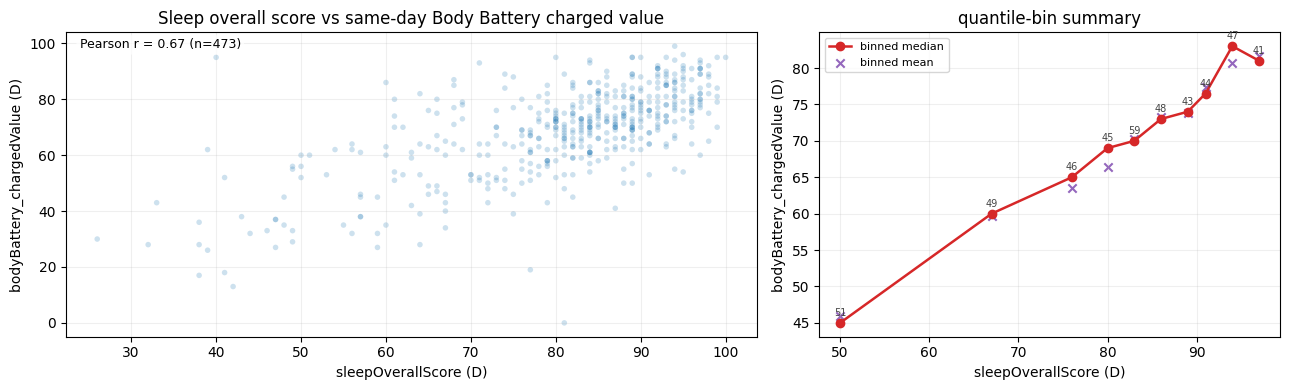

In [16]:
sleep_to_day_specs = [
    ('sleep_total_hours', 'allDayStress_AWAKE_averageStressLevel', 'Sleep duration vs same-day awake stress', 'sleep_total_hours (D)', 'awake stress (D)', 'rel_sleep_hours_to_awake_stress_same_day'),
    ('sleepOverallScore', 'allDayStress_AWAKE_averageStressLevel', 'Sleep overall score vs same-day awake stress', 'sleepOverallScore (D)', 'awake stress (D)', 'rel_sleep_score_to_awake_stress_same_day'),
    ('sleep_total_hours', 'active_hours', 'Sleep duration vs same-day active hours', 'sleep_total_hours (D)', 'active_hours (D)', 'rel_sleep_hours_to_active_hours_same_day'),
    ('sleepOverallScore', 'bodyBatteryHighest', 'Sleep overall score vs same-day Body Battery highest', 'sleepOverallScore (D)', 'bodyBatteryHighest (D)', 'rel_sleep_score_to_bb_highest_same_day'),
    ('sleepOverallScore', 'bodyBattery_chargedValue', 'Sleep overall score vs same-day Body Battery charged value', 'sleepOverallScore (D)', 'bodyBattery_chargedValue (D)', 'rel_sleep_score_to_bb_charged_same_day'),
]
for xcol, ycol, title, xlabel, ylabel, fig_name in sleep_to_day_specs:
    plot_relationship(df_sleep_e, xcol, ycol, title=title, xlabel=xlabel, ylabel=ylabel, fig_name=fig_name)


### 1.3 Daytime stress/activity -> next-night sleep (`D -> D+1 sleep`)

This is the main directional hypothesis block for questions like “does a stressful day degrade the following night?”.


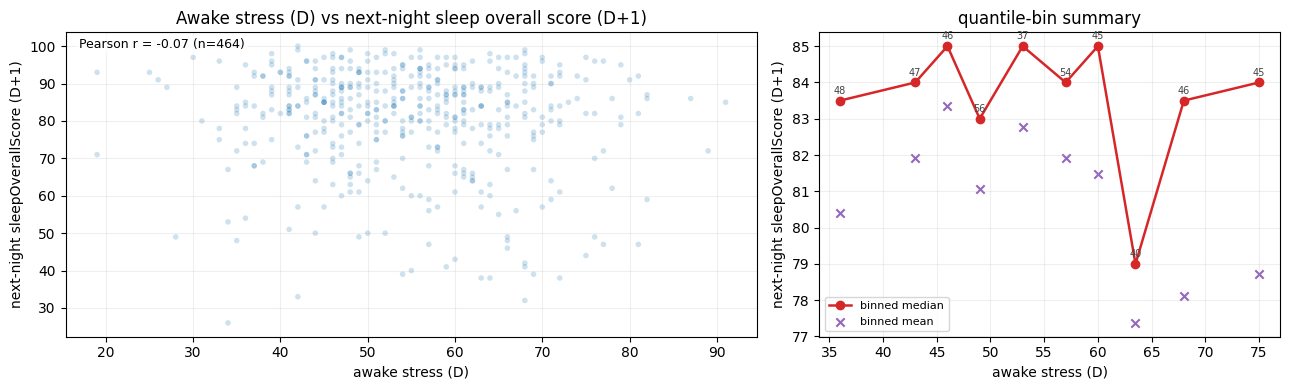

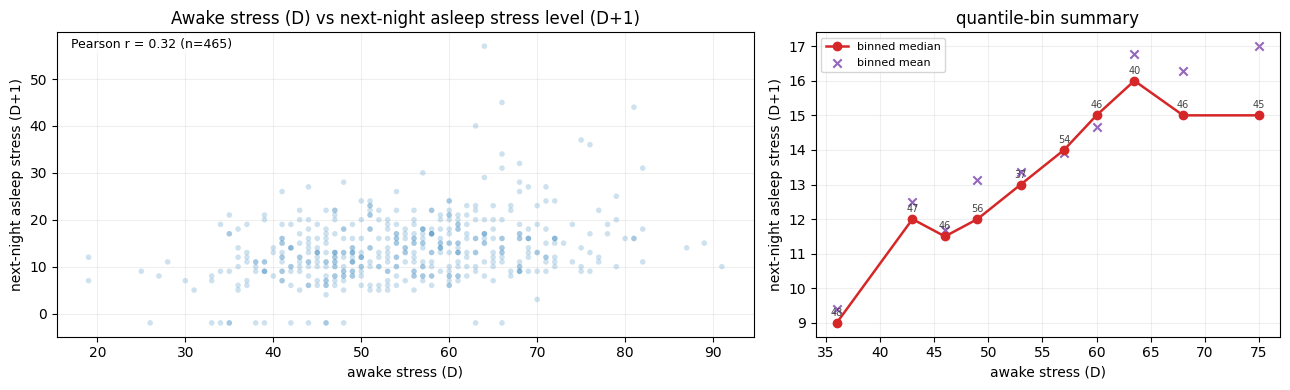

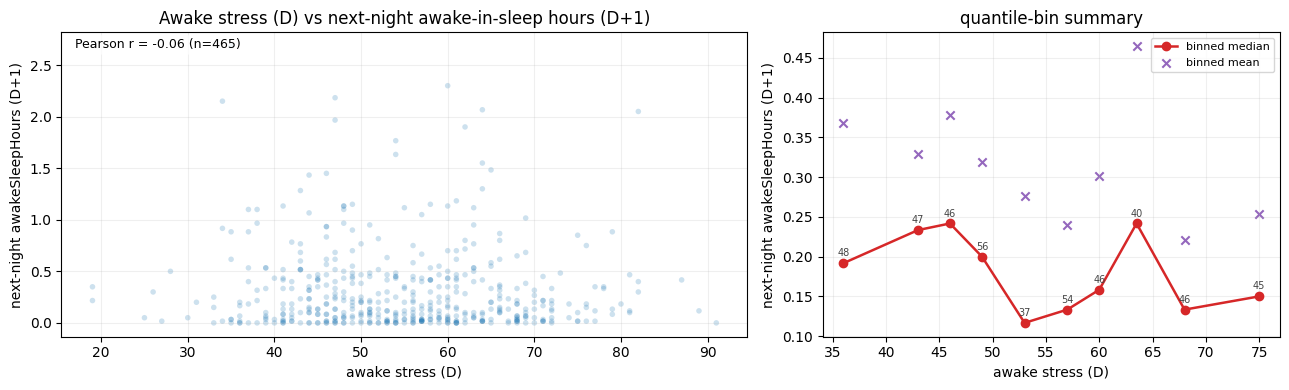

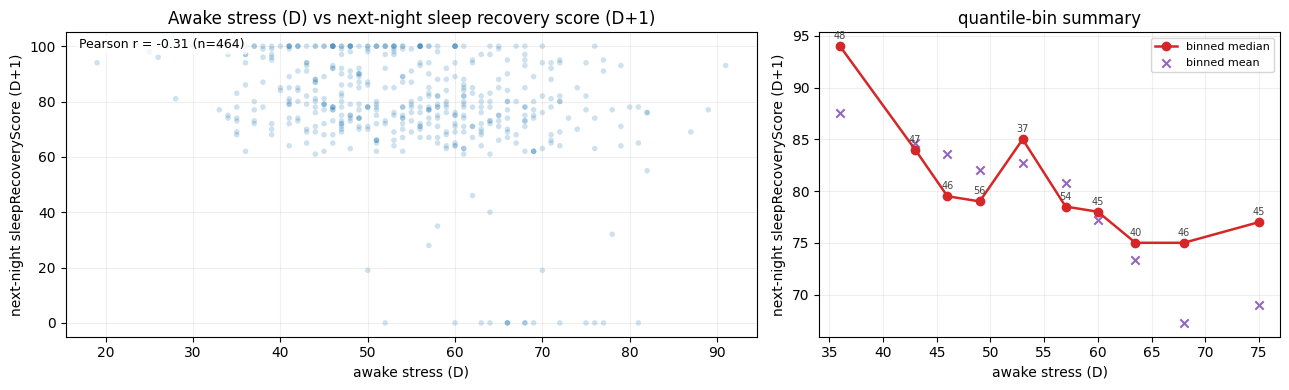

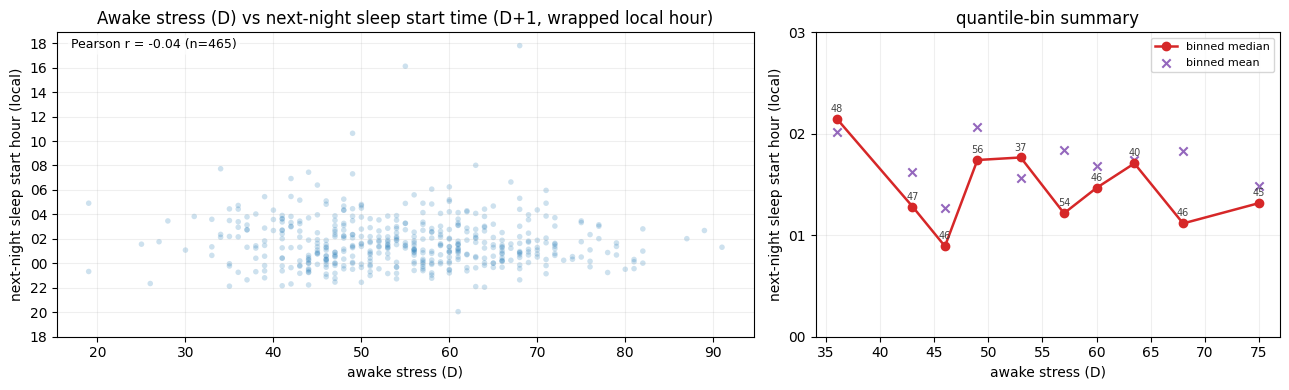

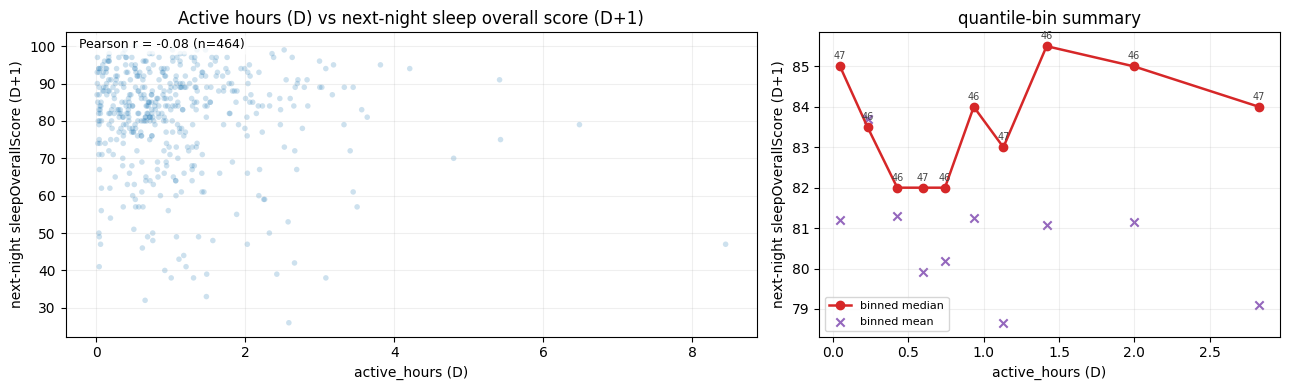

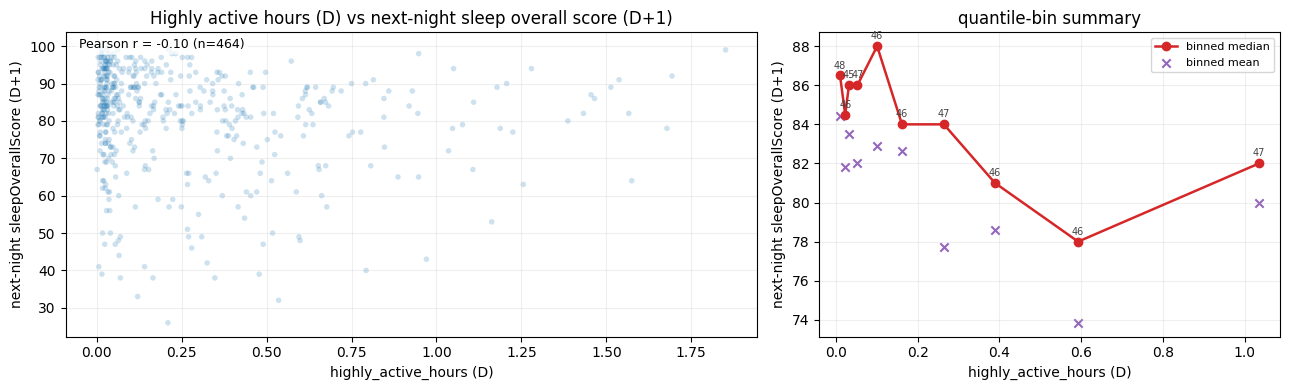

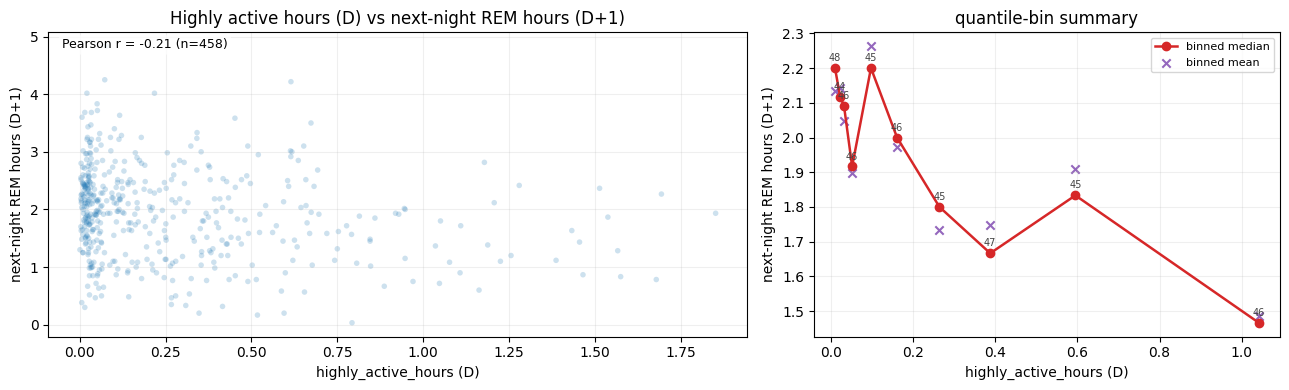

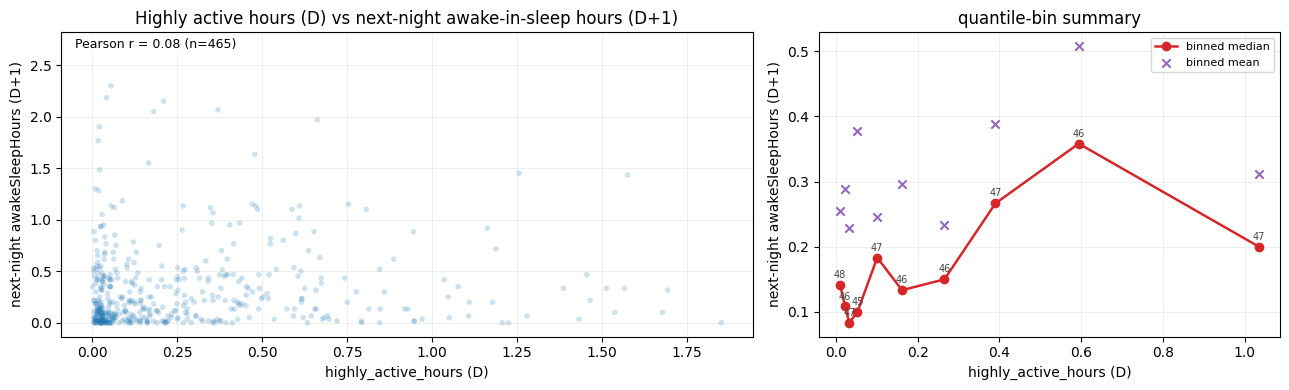

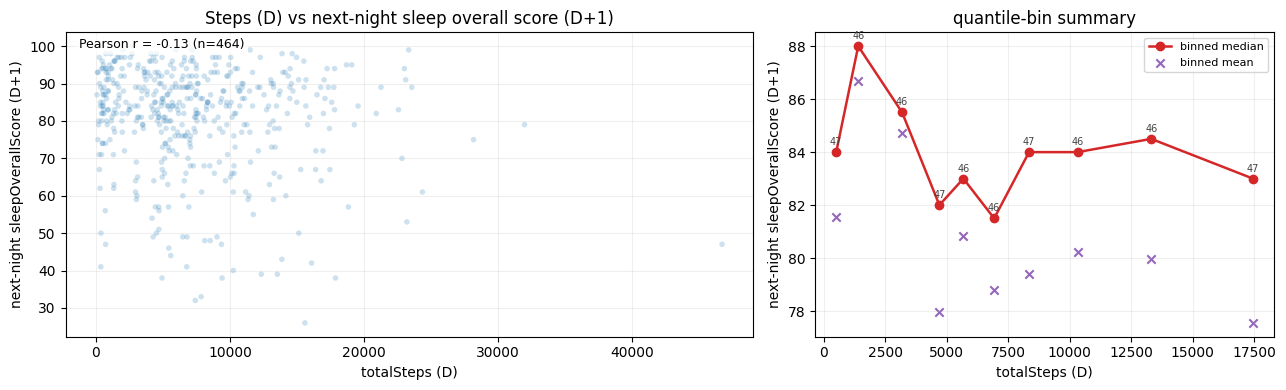

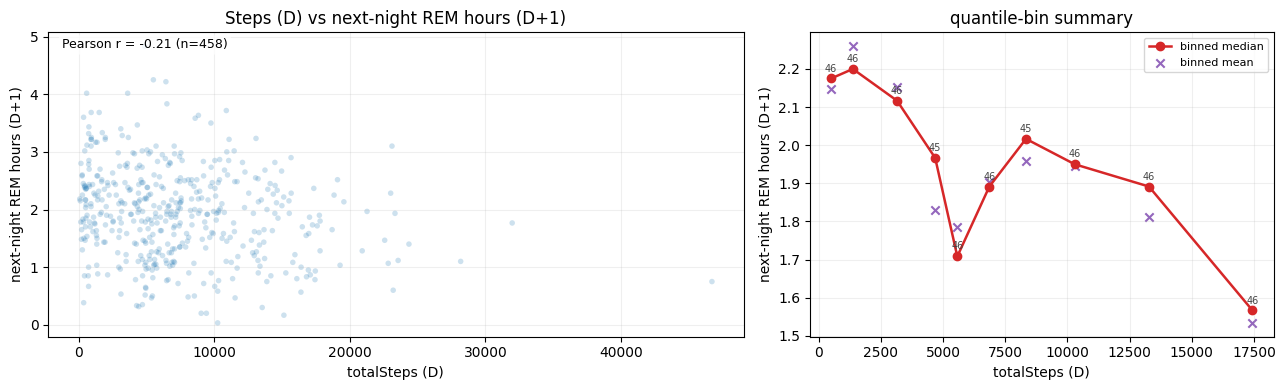

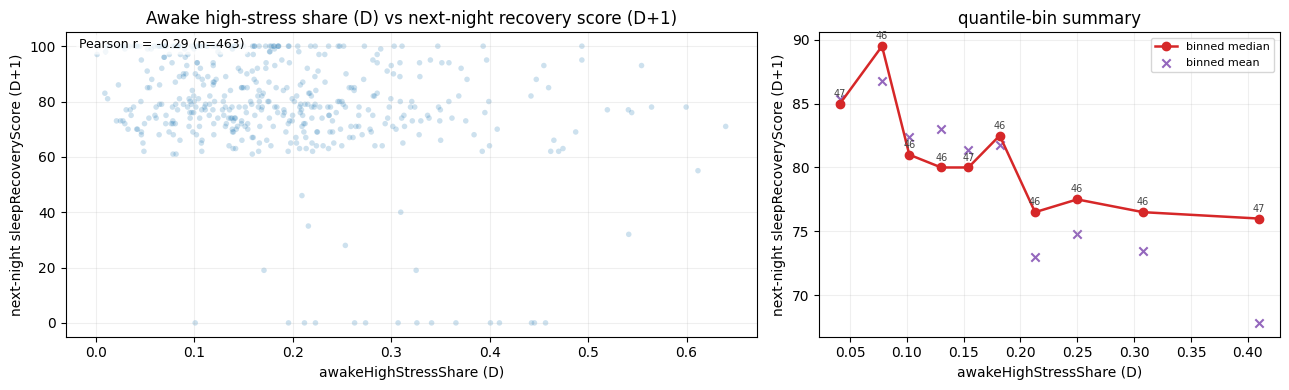

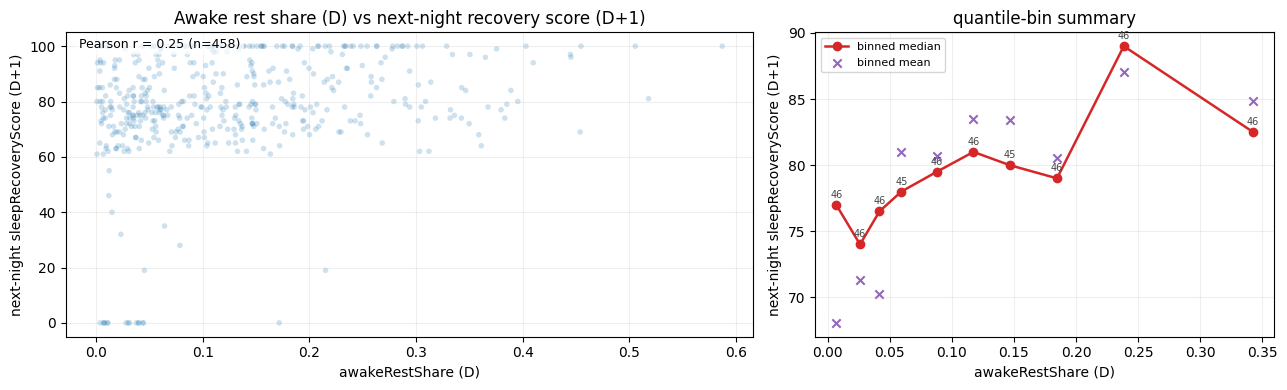

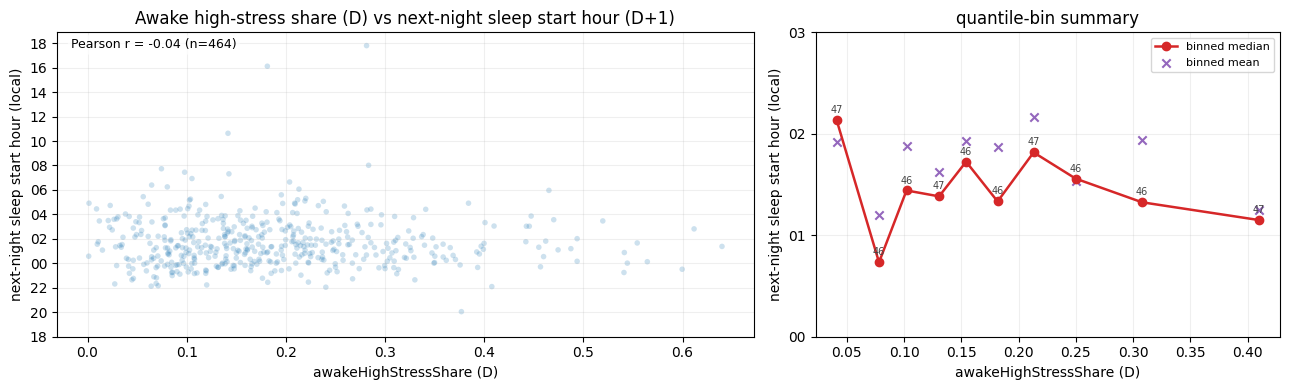

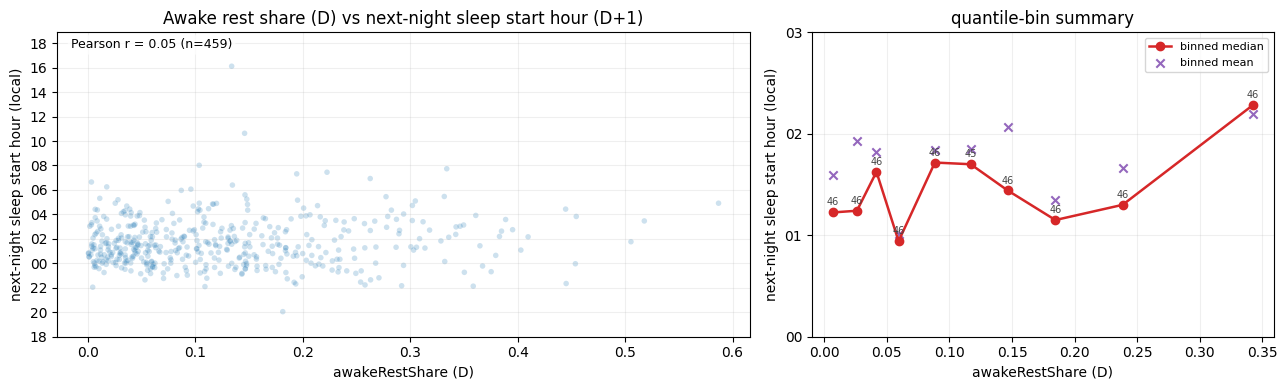

In [17]:
day_to_nextsleep_specs = [
    ('allDayStress_AWAKE_averageStressLevel', 'nextsleep_sleepOverallScore', 'Awake stress (D) vs next-night sleep overall score (D+1)', 'awake stress (D)', 'next-night sleepOverallScore (D+1)', 'rel_awake_stress_to_nextsleep_score', False, False),
    ('allDayStress_AWAKE_averageStressLevel', 'nextsleep_sleepAverageStressLevel', 'Awake stress (D) vs next-night asleep stress level (D+1)', 'awake stress (D)', 'next-night asleep stress (D+1)', 'rel_awake_stress_to_nextsleep_asleep_stress', False, False),
    ('allDayStress_AWAKE_averageStressLevel', 'nextsleep_awakeSleepHours', 'Awake stress (D) vs next-night awake-in-sleep hours (D+1)', 'awake stress (D)', 'next-night awakeSleepHours (D+1)', 'rel_awake_stress_to_nextsleep_awake_hours', False, False),
    ('allDayStress_AWAKE_averageStressLevel', 'nextsleep_sleepRecoveryScore', 'Awake stress (D) vs next-night sleep recovery score (D+1)', 'awake stress (D)', 'next-night sleepRecoveryScore (D+1)', 'rel_awake_stress_to_nextsleep_recovery', False, False),
    ('allDayStress_AWAKE_averageStressLevel', 'nextsleep_sleep_start_hour_local_wrapped', 'Awake stress (D) vs next-night sleep start time (D+1, wrapped local hour)', 'awake stress (D)', 'next-night sleep start hour (local)', 'rel_awake_stress_to_nextsleep_start_hour_wrapped', False, True),
    ('active_hours', 'nextsleep_sleepOverallScore', 'Active hours (D) vs next-night sleep overall score (D+1)', 'active_hours (D)', 'next-night sleepOverallScore (D+1)', 'rel_active_hours_to_nextsleep_score', False, False),
    ('highly_active_hours', 'nextsleep_sleepOverallScore', 'Highly active hours (D) vs next-night sleep overall score (D+1)', 'highly_active_hours (D)', 'next-night sleepOverallScore (D+1)', 'rel_highly_active_hours_to_nextsleep_score', False, False),
    ('highly_active_hours', 'nextsleep_remSleepHours', 'Highly active hours (D) vs next-night REM hours (D+1)', 'highly_active_hours (D)', 'next-night REM hours (D+1)', 'rel_highly_active_hours_to_nextsleep_rem', False, False),
    ('highly_active_hours', 'nextsleep_awakeSleepHours', 'Highly active hours (D) vs next-night awake-in-sleep hours (D+1)', 'highly_active_hours (D)', 'next-night awakeSleepHours (D+1)', 'rel_highly_active_hours_to_nextsleep_awake_hours', False, False),
    ('totalSteps', 'nextsleep_sleepOverallScore', 'Steps (D) vs next-night sleep overall score (D+1)', 'totalSteps (D)', 'next-night sleepOverallScore (D+1)', 'rel_steps_to_nextsleep_score', False, False),
    ('totalSteps', 'nextsleep_remSleepHours', 'Steps (D) vs next-night REM hours (D+1)', 'totalSteps (D)', 'next-night REM hours (D+1)', 'rel_steps_to_nextsleep_rem', False, False),
    ('awakeHighStressShare', 'nextsleep_sleepRecoveryScore', 'Awake high-stress share (D) vs next-night recovery score (D+1)', 'awakeHighStressShare (D)', 'next-night sleepRecoveryScore (D+1)', 'rel_awake_high_stress_share_to_nextsleep_recovery', False, False),
    ('awakeRestShare', 'nextsleep_sleepRecoveryScore', 'Awake rest share (D) vs next-night recovery score (D+1)', 'awakeRestShare (D)', 'next-night sleepRecoveryScore (D+1)', 'rel_awake_rest_share_to_nextsleep_recovery', False, False),
    ('awakeHighStressShare', 'nextsleep_sleep_start_hour_local_wrapped', 'Awake high-stress share (D) vs next-night sleep start hour (D+1)', 'awakeHighStressShare (D)', 'next-night sleep start hour (local)', 'rel_awake_high_stress_share_to_nextsleep_start_hour_wrapped', False, True),
    ('awakeRestShare', 'nextsleep_sleep_start_hour_local_wrapped', 'Awake rest share (D) vs next-night sleep start hour (D+1)', 'awakeRestShare (D)', 'next-night sleep start hour (local)', 'rel_awake_rest_share_to_nextsleep_start_hour_wrapped', False, True),
]

# Safety guard: drop sentinel/out-of-range stress levels even if upstream cell was not rerun.
df_day_nextsleep_plot = df_day_nextsleep.copy()
for col in ['allDayStress_AWAKE_averageStressLevel', 'nextsleep_sleepAverageStressLevel']:
    if col in df_day_nextsleep_plot.columns:
        s = pd.to_numeric(df_day_nextsleep_plot[col], errors='coerce')
        bad_mask = ~(s.between(0, 100) | s.isna())
        if bad_mask.any():
            print(f'Filtered {int(bad_mask.sum())} out-of-range values in {col} for 4.3 plots')
        df_day_nextsleep_plot[col] = s.where(s.between(0, 100))

for xcol, ycol, title, xlabel, ylabel, fig_name, clock_axis_x, clock_axis_y in day_to_nextsleep_specs:
    plot_relationship(
        df_day_nextsleep_plot,
        xcol,
        ycol,
        title=title,
        xlabel=xlabel,
        ylabel=ylabel,
        fig_name=fig_name,
        clock_axis_x=clock_axis_x,
        clock_axis_y=clock_axis_y,
    )



### 1.4 Sleep-internal relationships (same-row, structural)

These relationships focus on the sleep subsystem itself (duration, timing, stress, stages, score). They are useful for understanding score behavior and formulating sleep-specific hypotheses.


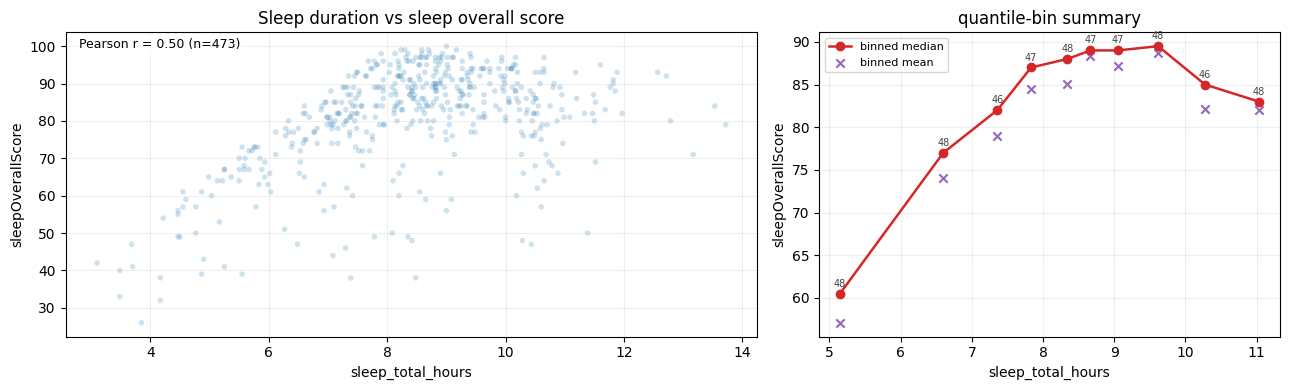

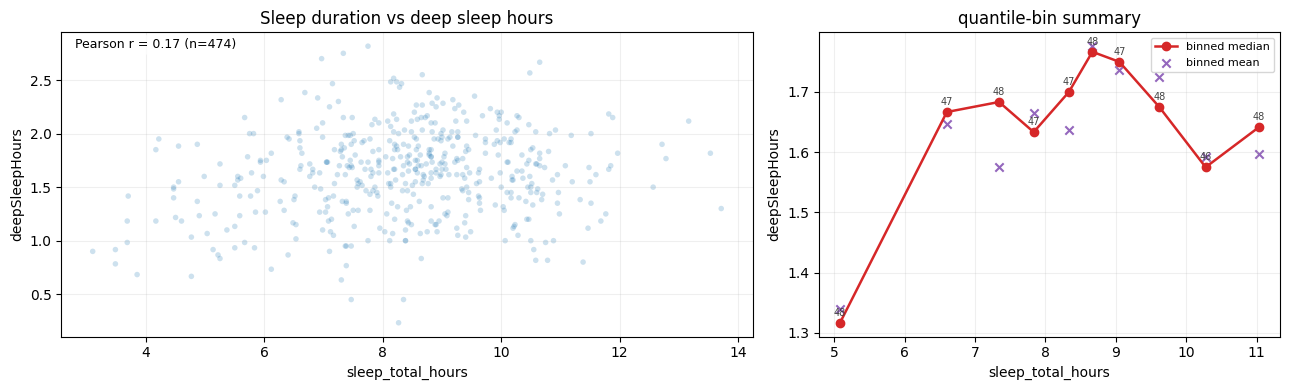

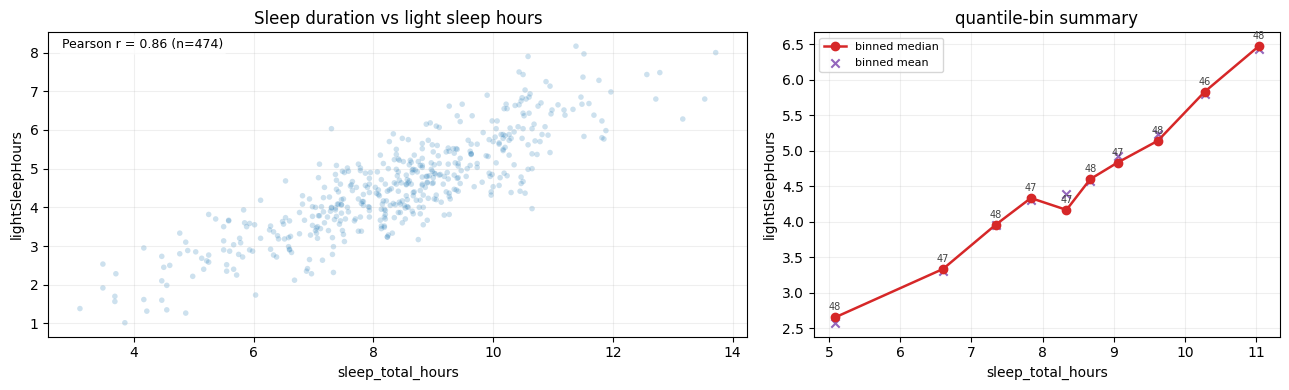

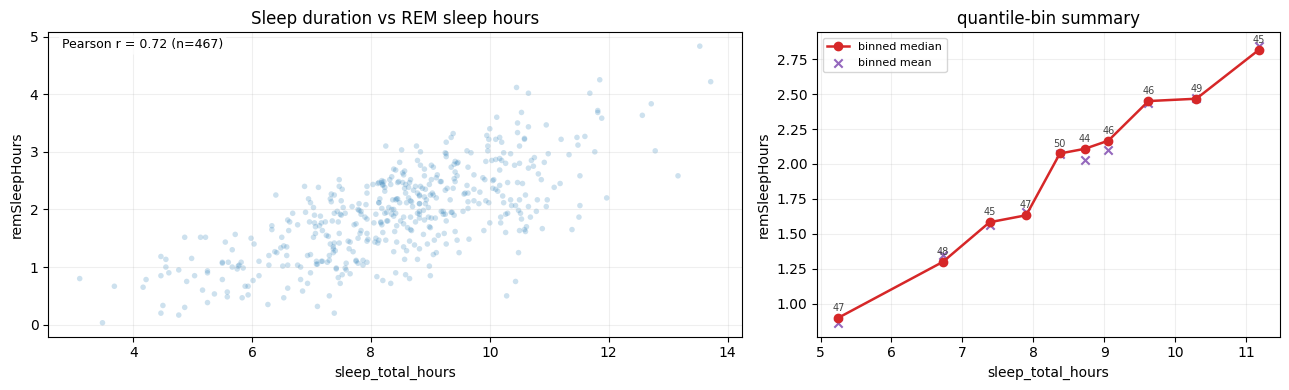

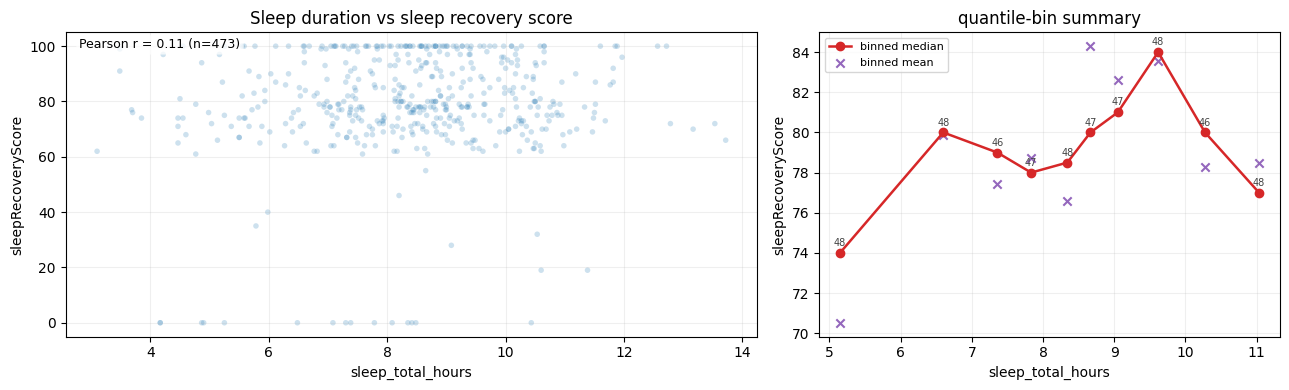

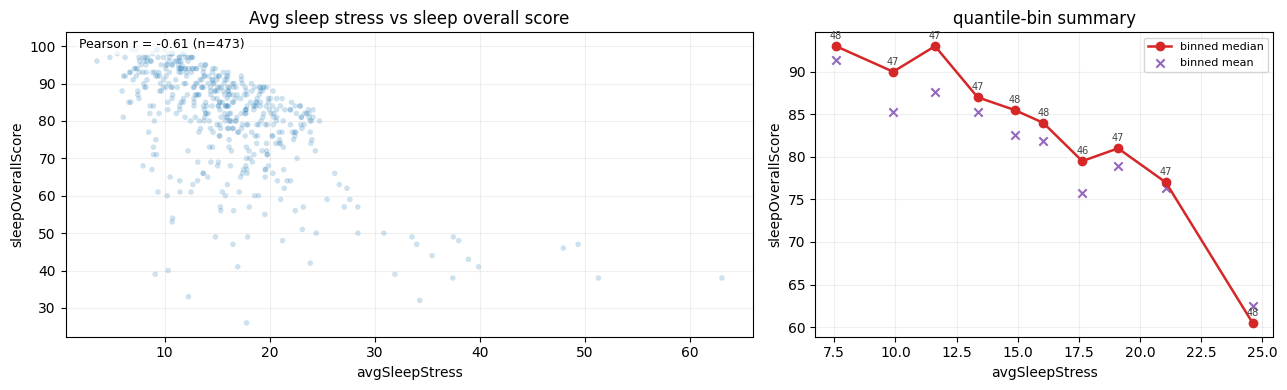

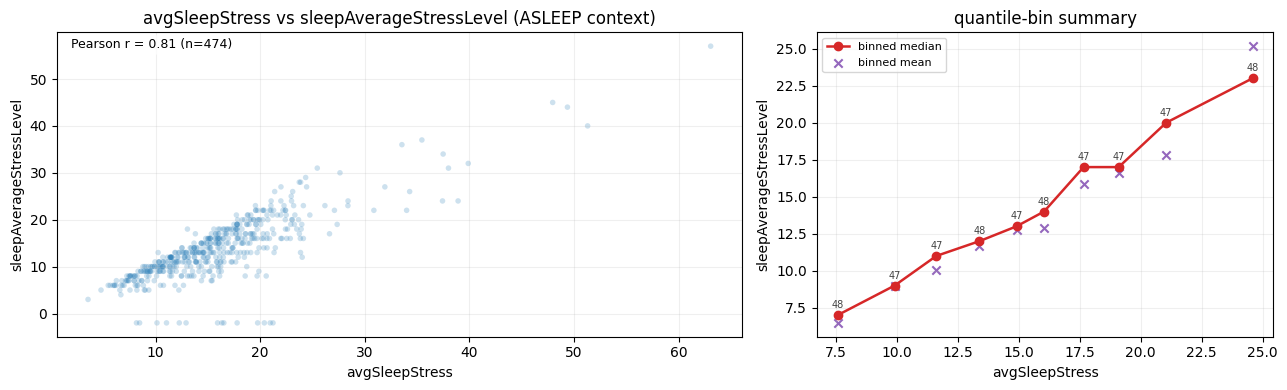

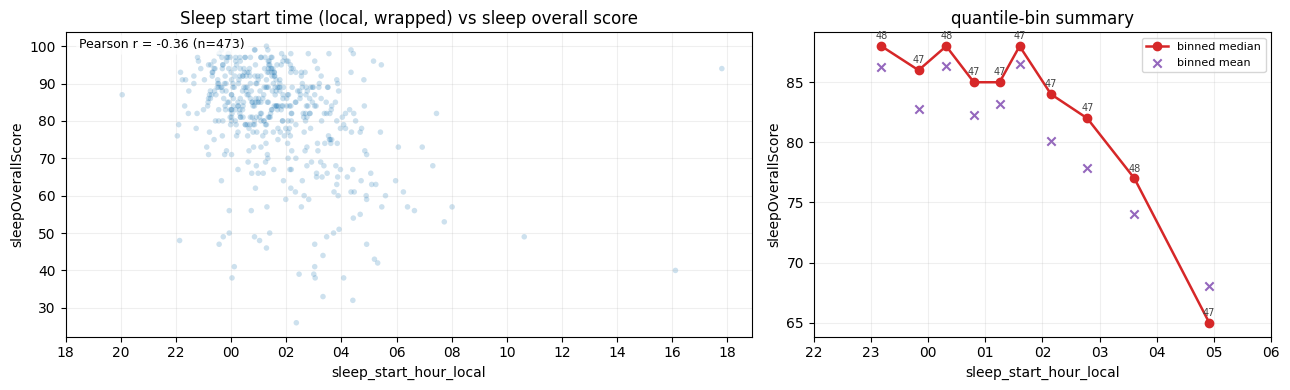

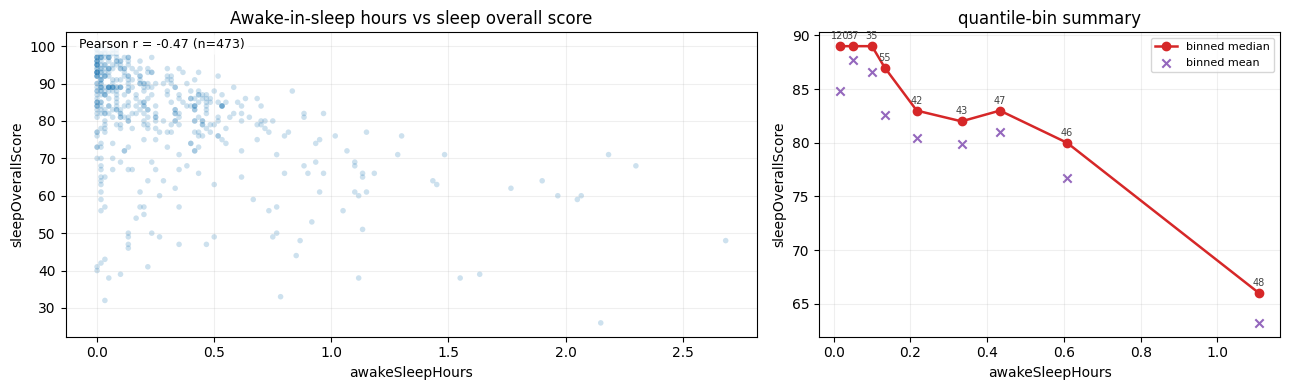

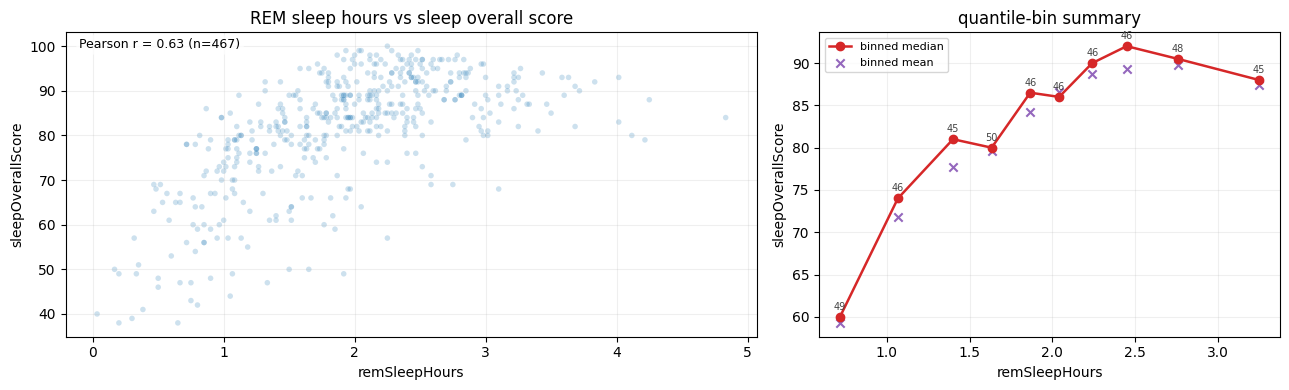

In [18]:
sleep_internal_specs = [
    ('sleep_total_hours', 'sleepOverallScore', 'Sleep duration vs sleep overall score', 'sleep_total_hours', 'sleepOverallScore', 'rel_sleep_hours_vs_sleep_score_same_row', False, False),
    ('sleep_total_hours', 'deepSleepHours', 'Sleep duration vs deep sleep hours', 'sleep_total_hours', 'deepSleepHours', 'rel_sleep_hours_vs_deep_sleep_hours', False, False),
    ('sleep_total_hours', 'lightSleepHours', 'Sleep duration vs light sleep hours', 'sleep_total_hours', 'lightSleepHours', 'rel_sleep_hours_vs_light_sleep_hours', False, False),
    ('sleep_total_hours', 'remSleepHours', 'Sleep duration vs REM sleep hours', 'sleep_total_hours', 'remSleepHours', 'rel_sleep_hours_vs_rem_sleep_hours', False, False),
    ('sleep_total_hours', 'sleepRecoveryScore', 'Sleep duration vs sleep recovery score', 'sleep_total_hours', 'sleepRecoveryScore', 'rel_sleep_hours_vs_sleep_recovery_score', False, False),
    ('sleepAverageStressLevel', 'sleepOverallScore', 'Sleep average stress level vs sleep overall score', 'sleepAverageStressLevel', 'sleepOverallScore', 'rel_sleep_avg_stress_level_vs_sleep_score', False, False),
    ('avgSleepStress', 'sleepAverageStressLevel', 'avgSleepStress vs sleepAverageStressLevel (ASLEEP context)', 'avgSleepStress', 'sleepAverageStressLevel', 'rel_avg_sleep_stress_vs_sleep_average_stress_level', False, False),
    ('sleep_start_hour_local_wrapped', 'sleepOverallScore', 'Sleep start time (local, wrapped) vs sleep overall score', 'sleep_start_hour_local', 'sleepOverallScore', 'rel_sleep_start_hour_local_wrapped_vs_sleep_score', True, False),
    ('awakeSleepHours', 'sleepOverallScore', 'Awake-in-sleep hours vs sleep overall score', 'awakeSleepHours', 'sleepOverallScore', 'rel_awake_sleep_hours_vs_sleep_score', False, False),
    ('remSleepHours', 'sleepOverallScore', 'REM sleep hours vs sleep overall score', 'remSleepHours', 'sleepOverallScore', 'rel_rem_sleep_hours_vs_sleep_score', False, False),
]
for xcol, ycol, title, xlabel, ylabel, fig_name, clock_axis_x, clock_axis_y in sleep_internal_specs:
    plot_relationship(
        df_sleep_e,
        xcol,
        ycol,
        title=title,
        xlabel=xlabel,
        ylabel=ylabel,
        fig_name=fig_name,
        clock_axis_x=clock_axis_x,
        clock_axis_y=clock_axis_y,
    )




### 1.5 Exploratory same-day daytime interactions (optional / hypothesis seeding)

These are exploratory same-day daytime pairings. Keep them as pattern-discovery tools (not strong directional claims) unless a clear temporal mechanism is specified.


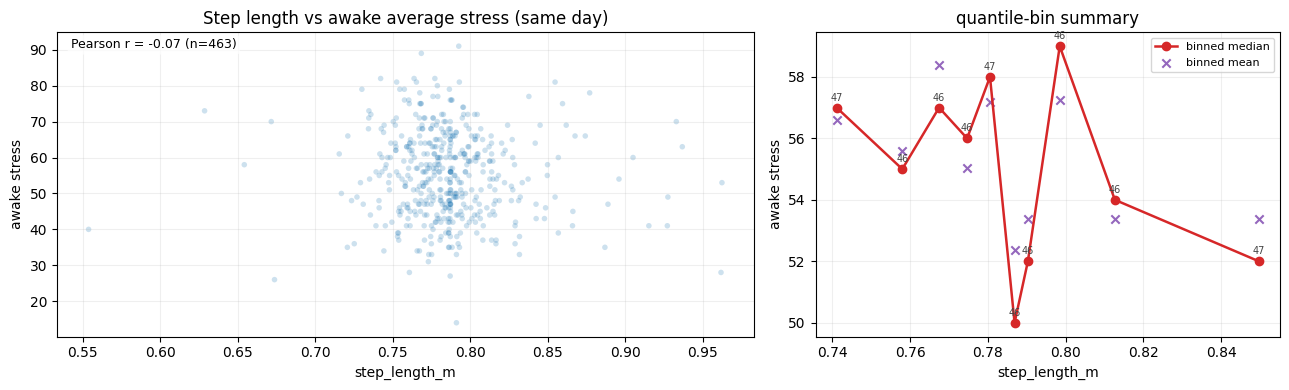

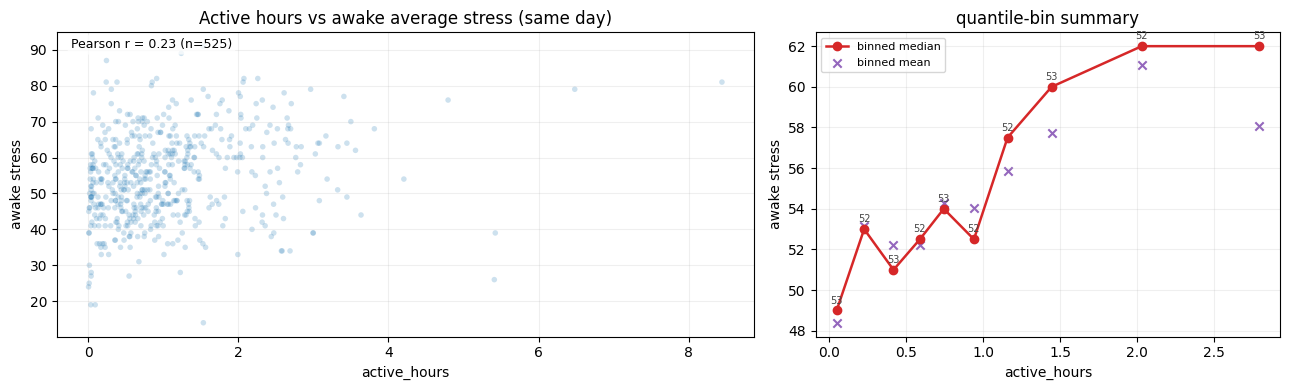

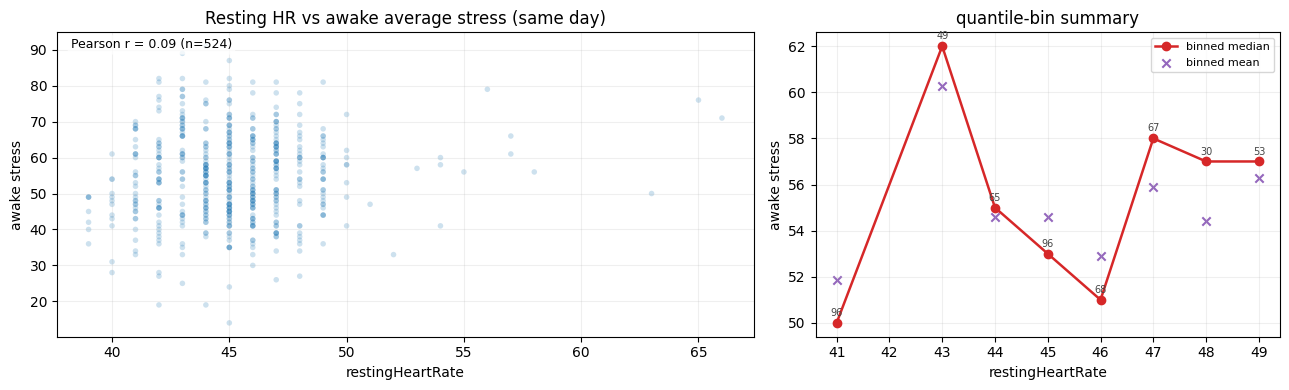

In [19]:
same_day_exploratory_specs = [
    ('step_length_m', 'allDayStress_AWAKE_averageStressLevel', 'Step length vs awake average stress (same day)', 'step_length_m', 'awake stress', 'rel_step_length_vs_awake_stress'),
    ('active_hours', 'allDayStress_AWAKE_averageStressLevel', 'Active hours vs awake average stress (same day)', 'active_hours', 'awake stress', 'rel_active_hours_vs_awake_stress_same_day'),
    ('restingHeartRate', 'allDayStress_AWAKE_averageStressLevel', 'Resting HR vs awake average stress (same day)', 'restingHeartRate', 'awake stress', 'rel_resting_hr_vs_awake_stress_same_day'),
]
for xcol, ycol, title, xlabel, ylabel, fig_name in same_day_exploratory_specs:
    plot_relationship(df_strict_e, xcol, ycol, title=title, xlabel=xlabel, ylabel=ylabel, fig_name=fig_name)


### 1.6 Correlation matrices (grouped `core` / `extended` submatrices)

Instead of one giant matrix, build **curated submatrices** with explicit temporal semantics and grouped feature sets:
- `asleep(D)` (night metrics at start of day `D`)
- `awake(D)` (daytime activity/stress after waking, same `calendarDate`)
- `physiology_energy(D)` (heart + Body Battery summaries, mixed timing within day)
- `stress_asleep(D)` (Garmin ASLEEP stress sub-aggregator)
- optional `total(D)` stress summaries (supporting)

Core matrices are compact and readable; extended matrices add more variables (stages, respiration/SpO2, stress duration/share components, floors/distance, etc.). Correlation is **screening/triage**, not causal proof.


group        frame  n_metrics  n_present
0                 asleep_core_D   df_sleep_e         12         12
1             asleep_extended_D   df_sleep_e          6          6
2                  awake_core_D  df_strict_e          8          8
3              awake_extended_D  df_strict_e         10         10
4      physiology_energy_core_D  df_strict_e          6          6
5  physiology_energy_extended_D  df_strict_e          5          5
6          stress_asleep_core_D   df_sleep_e          6          6
7      stress_asleep_extended_D   df_sleep_e          7          7
8       stress_total_extended_D  df_strict_e          7          7

/var/folders/pz/8fjd1qc94418j8z0tl50g2yw0000gn/T/ipykernel_8724/3274604494.py:238: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  base_cmap = plt.cm.get_cmap('coolwarm')


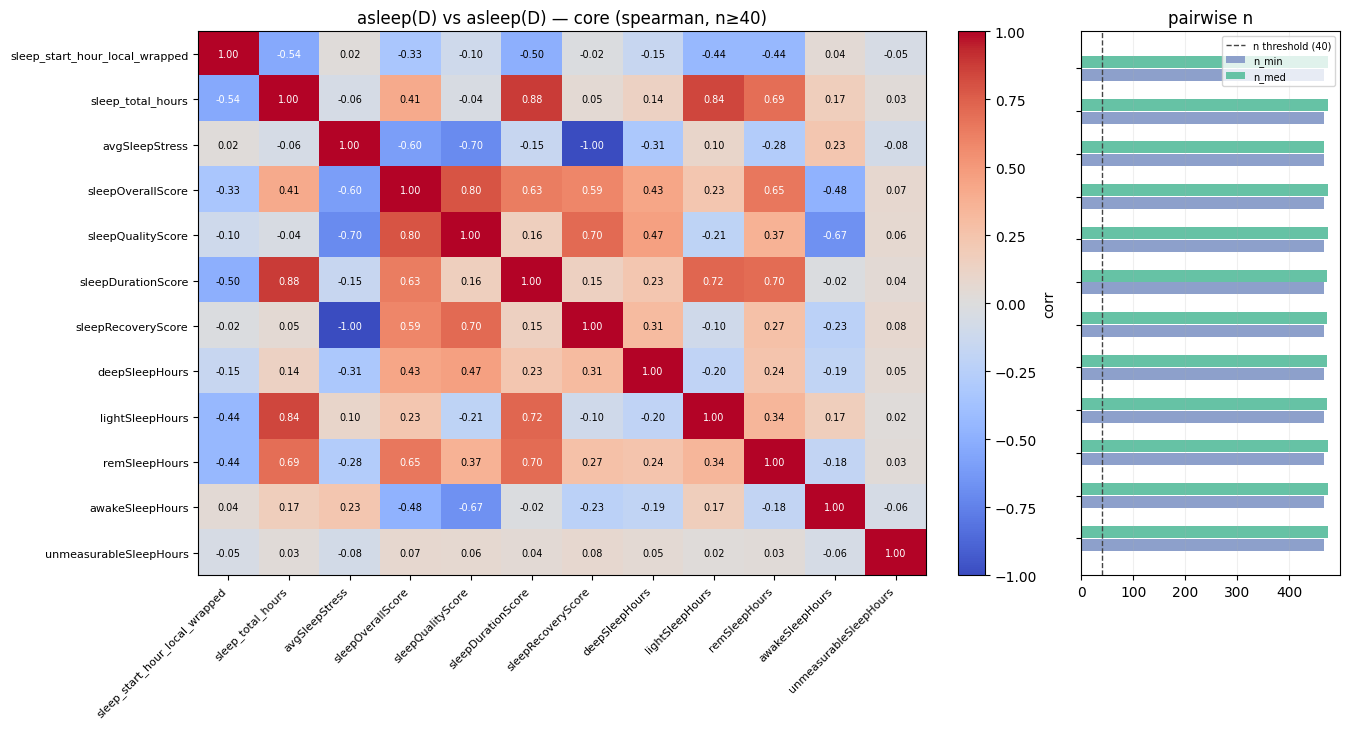

/var/folders/pz/8fjd1qc94418j8z0tl50g2yw0000gn/T/ipykernel_8724/3274604494.py:238: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  base_cmap = plt.cm.get_cmap('coolwarm')


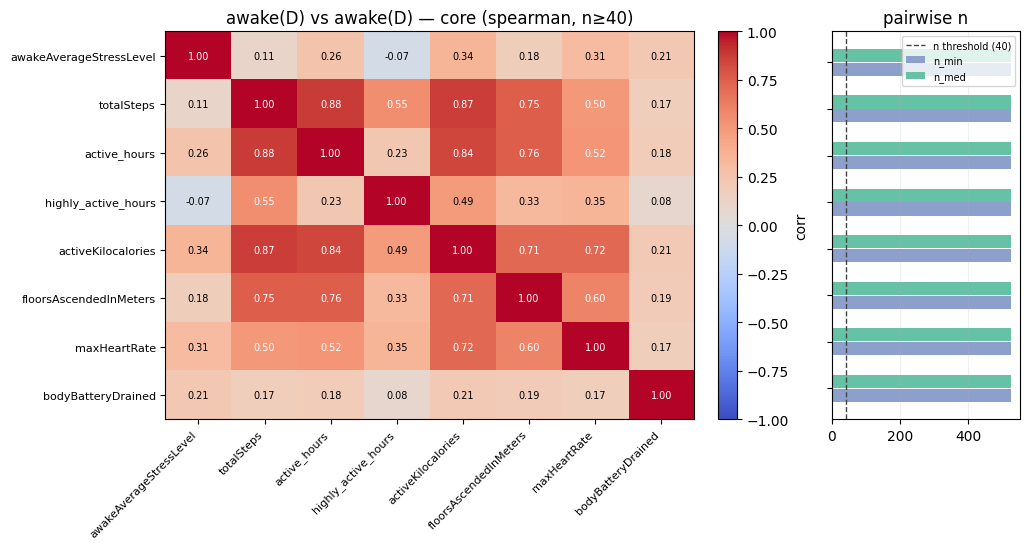

/var/folders/pz/8fjd1qc94418j8z0tl50g2yw0000gn/T/ipykernel_8724/3274604494.py:238: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  base_cmap = plt.cm.get_cmap('coolwarm')


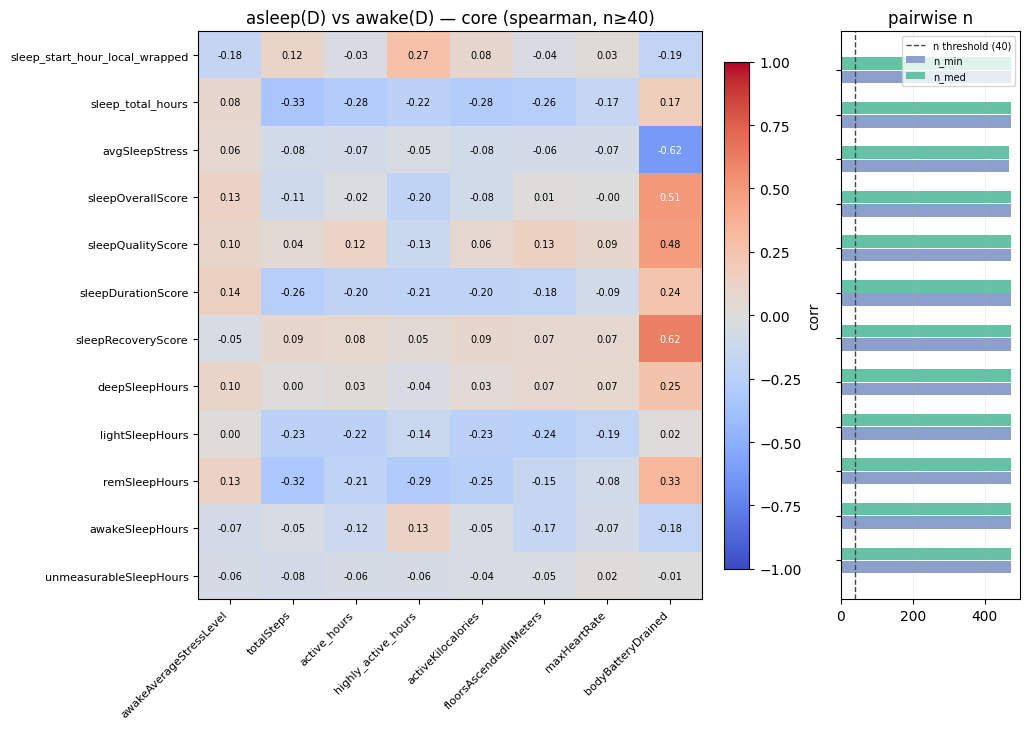

/var/folders/pz/8fjd1qc94418j8z0tl50g2yw0000gn/T/ipykernel_8724/3274604494.py:238: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  base_cmap = plt.cm.get_cmap('coolwarm')


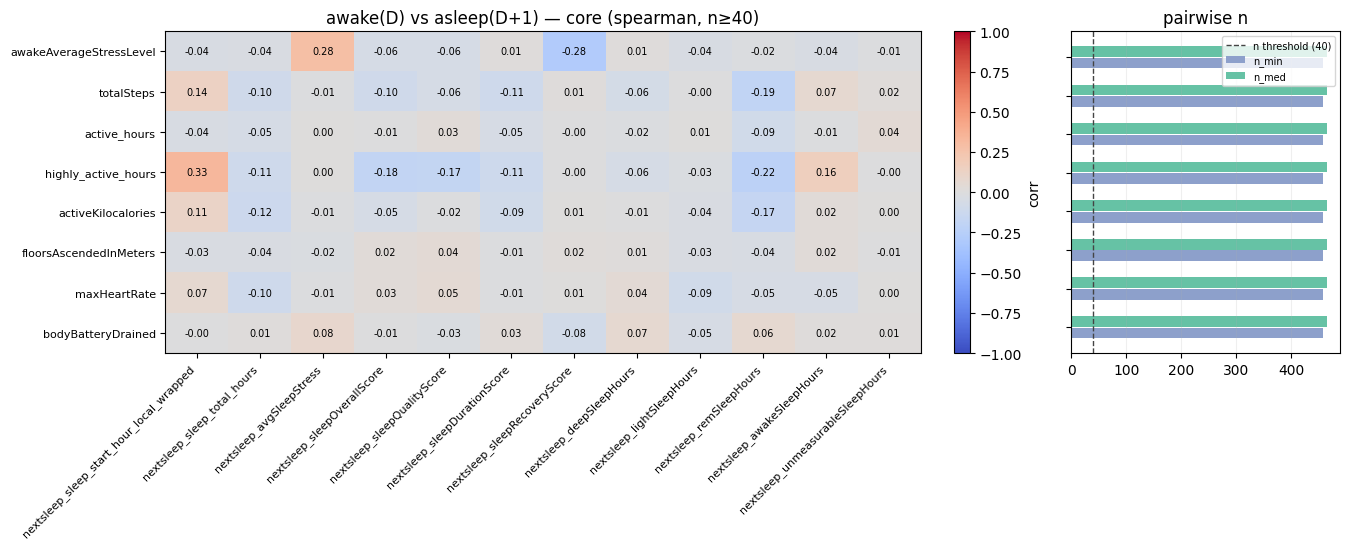

/var/folders/pz/8fjd1qc94418j8z0tl50g2yw0000gn/T/ipykernel_8724/3274604494.py:238: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  base_cmap = plt.cm.get_cmap('coolwarm')


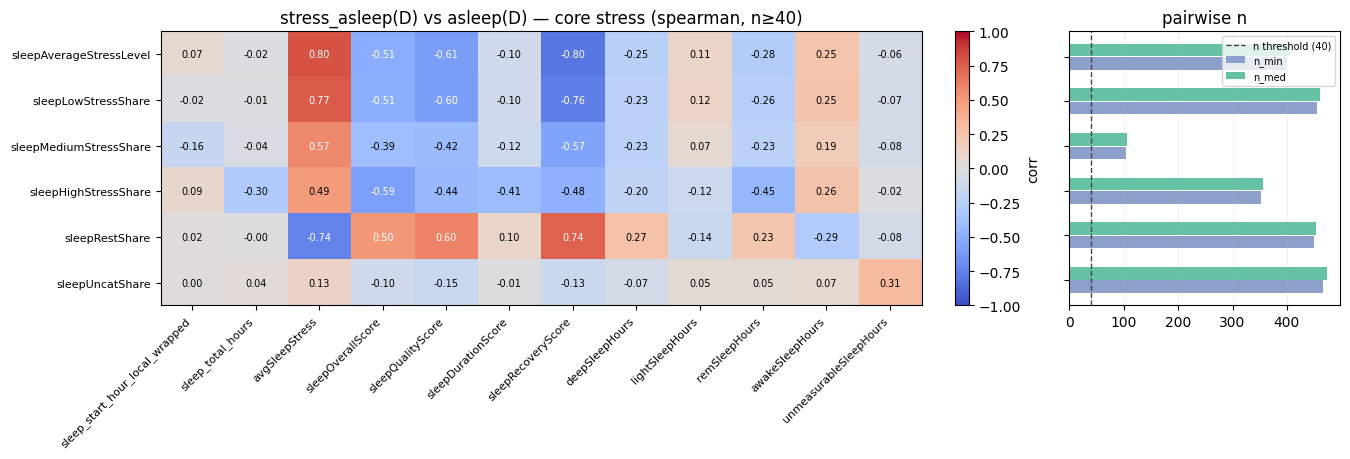

/var/folders/pz/8fjd1qc94418j8z0tl50g2yw0000gn/T/ipykernel_8724/3274604494.py:238: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  base_cmap = plt.cm.get_cmap('coolwarm')


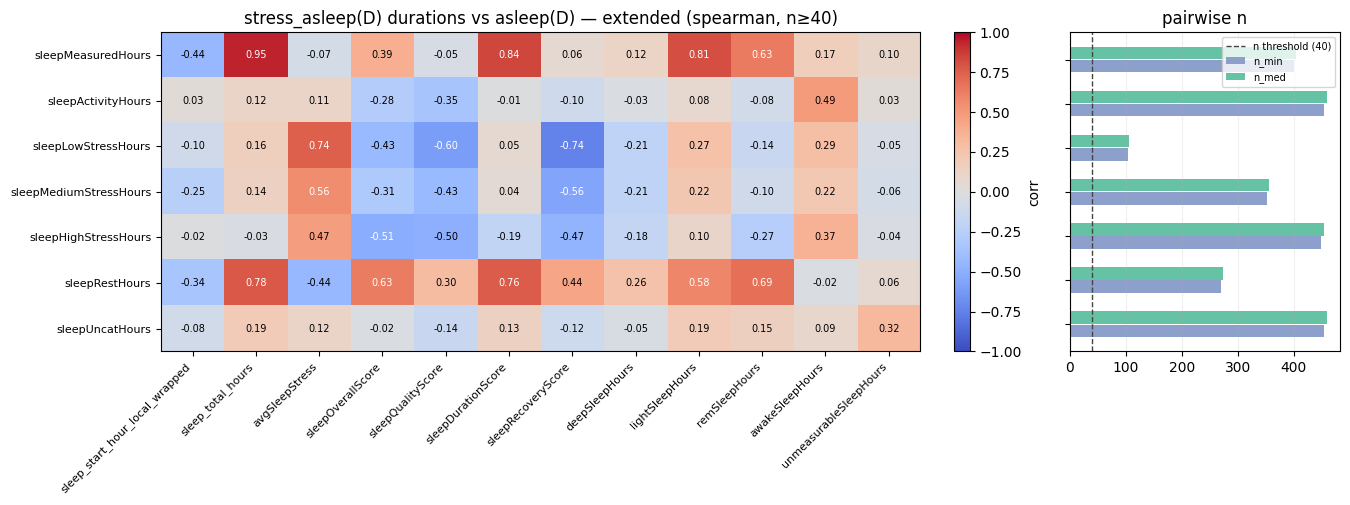

/var/folders/pz/8fjd1qc94418j8z0tl50g2yw0000gn/T/ipykernel_8724/3274604494.py:238: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  base_cmap = plt.cm.get_cmap('coolwarm')


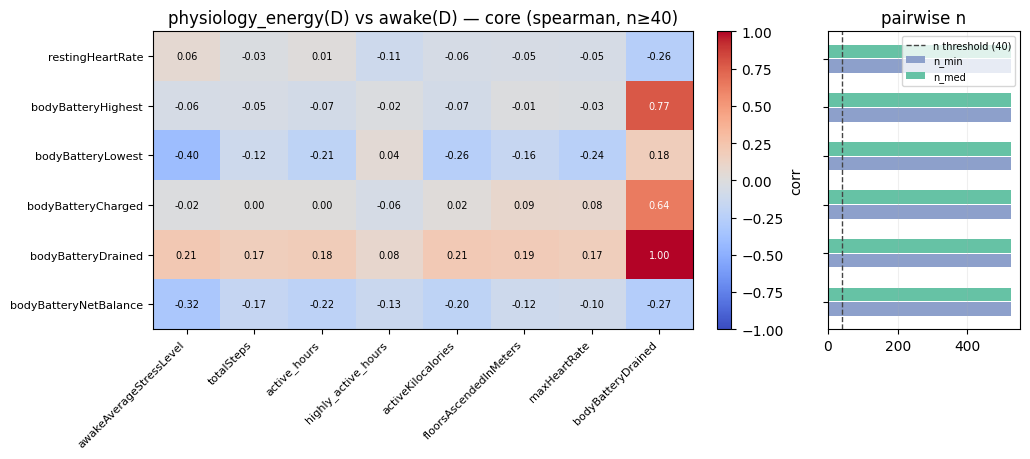

/var/folders/pz/8fjd1qc94418j8z0tl50g2yw0000gn/T/ipykernel_8724/3274604494.py:238: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  base_cmap = plt.cm.get_cmap('coolwarm')


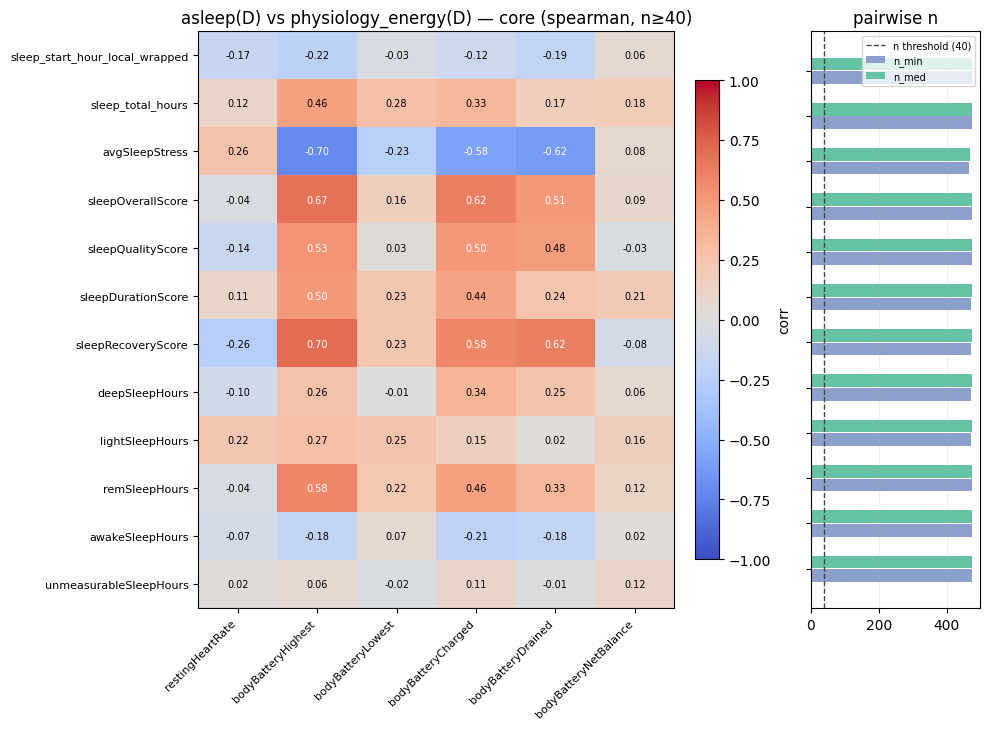

/var/folders/pz/8fjd1qc94418j8z0tl50g2yw0000gn/T/ipykernel_8724/3274604494.py:238: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  base_cmap = plt.cm.get_cmap('coolwarm')


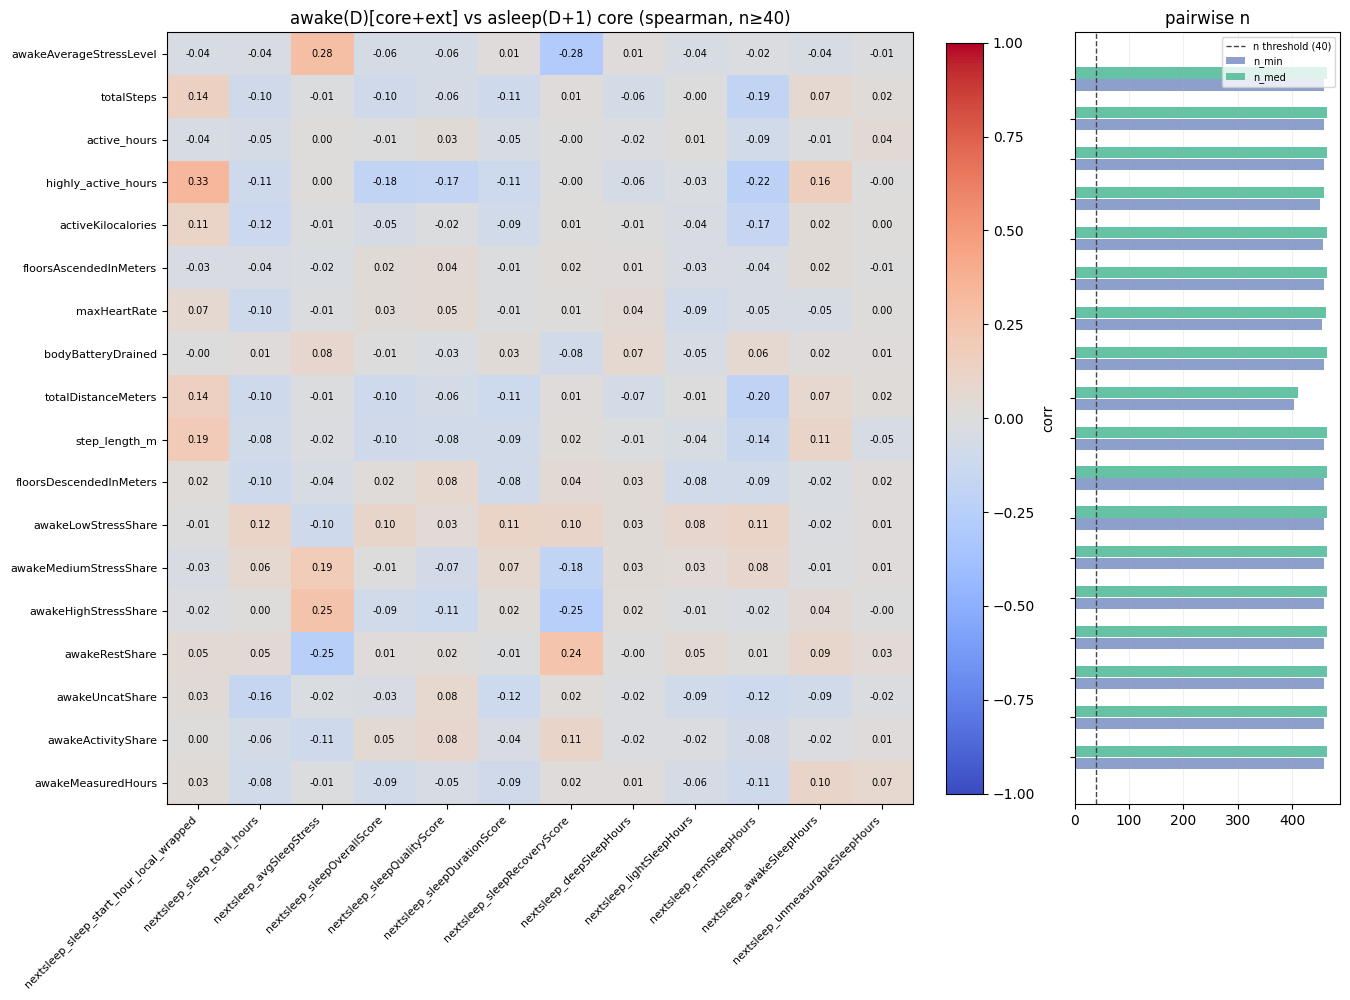

/var/folders/pz/8fjd1qc94418j8z0tl50g2yw0000gn/T/ipykernel_8724/3274604494.py:238: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  base_cmap = plt.cm.get_cmap('coolwarm')


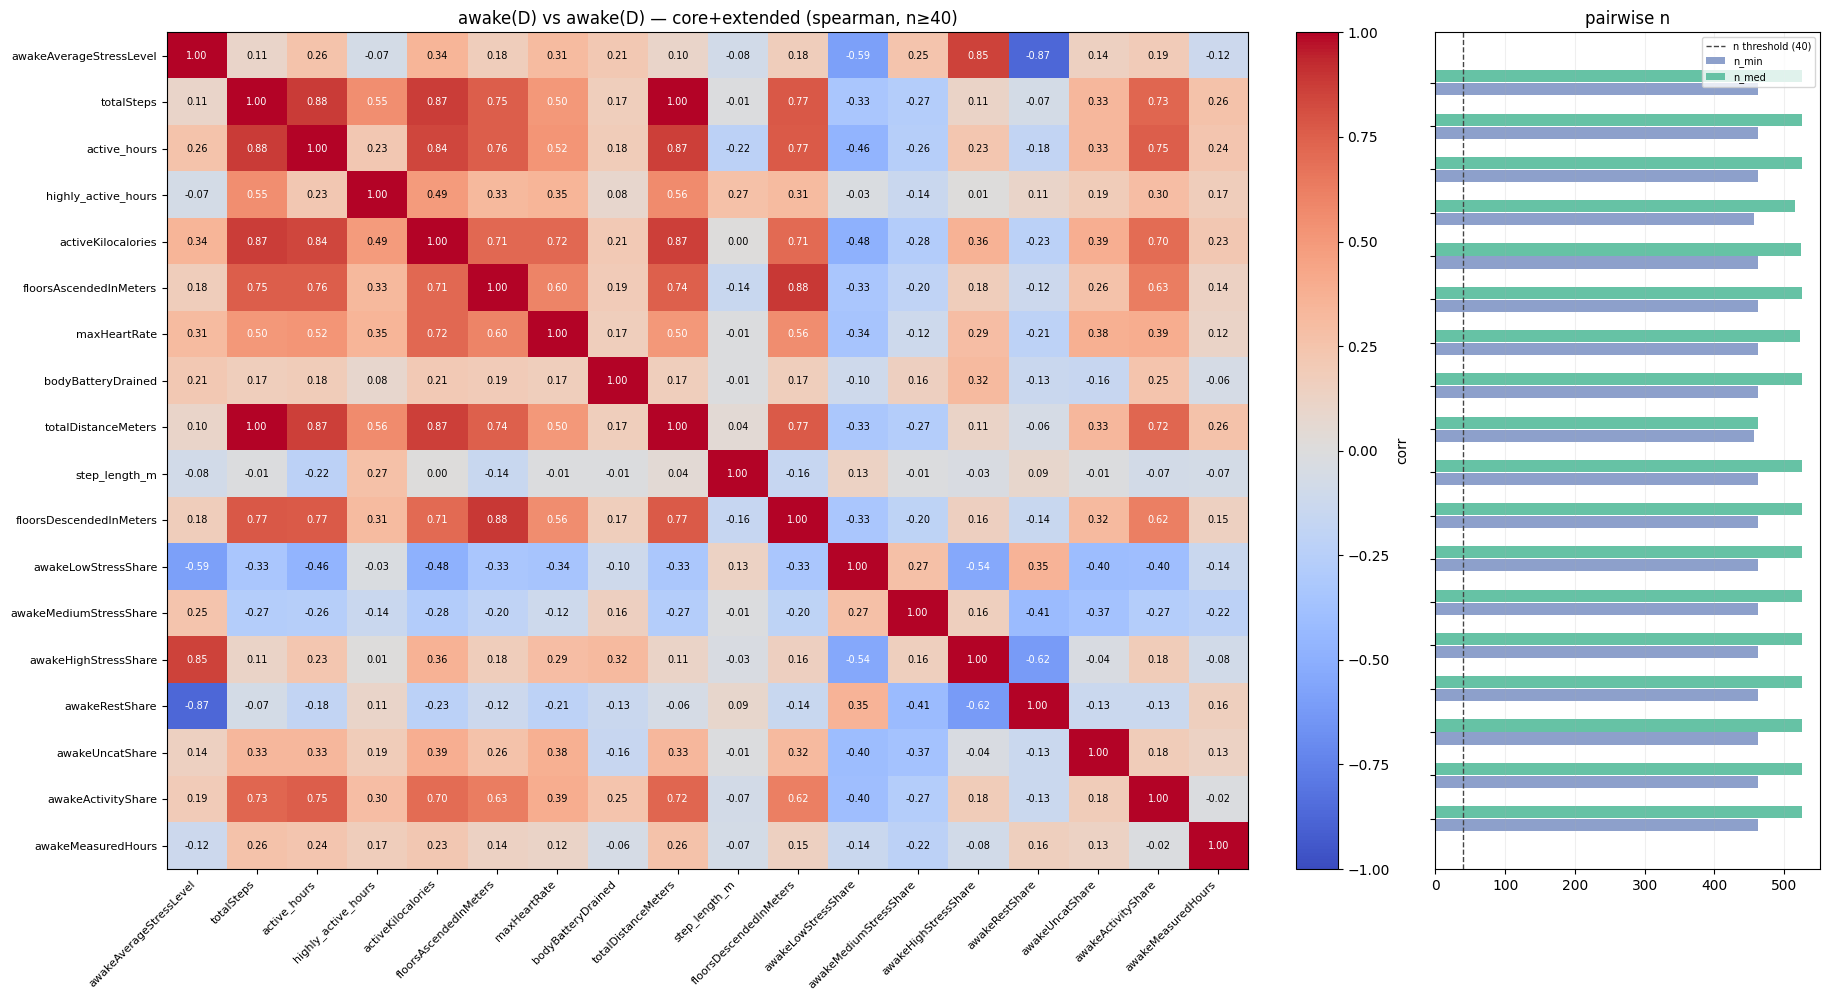

/var/folders/pz/8fjd1qc94418j8z0tl50g2yw0000gn/T/ipykernel_8724/3274604494.py:238: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  base_cmap = plt.cm.get_cmap('coolwarm')


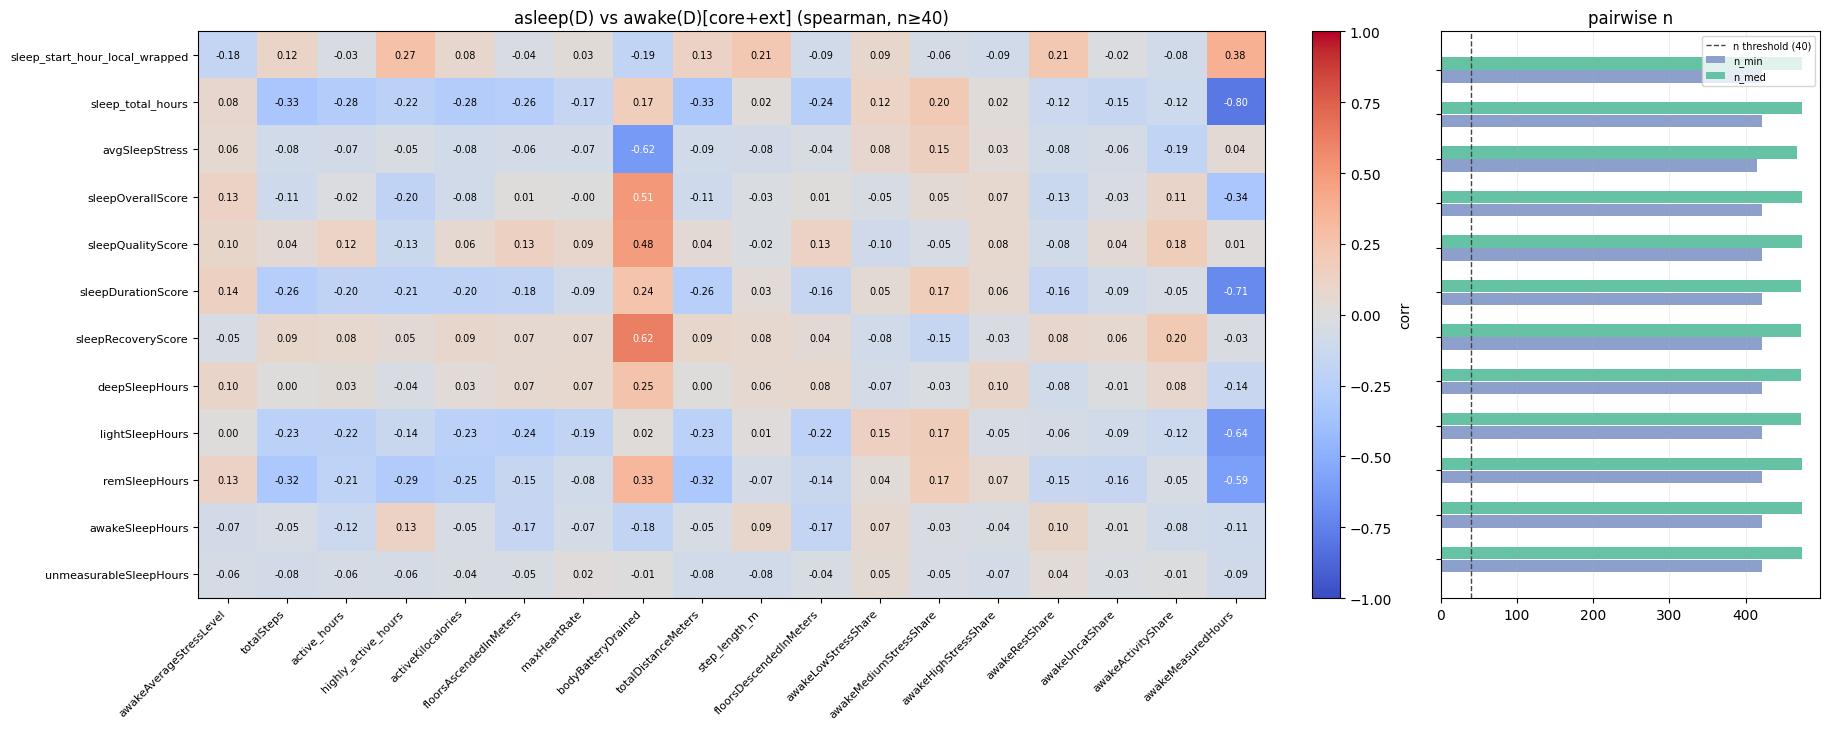

/var/folders/pz/8fjd1qc94418j8z0tl50g2yw0000gn/T/ipykernel_8724/3274604494.py:238: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  base_cmap = plt.cm.get_cmap('coolwarm')


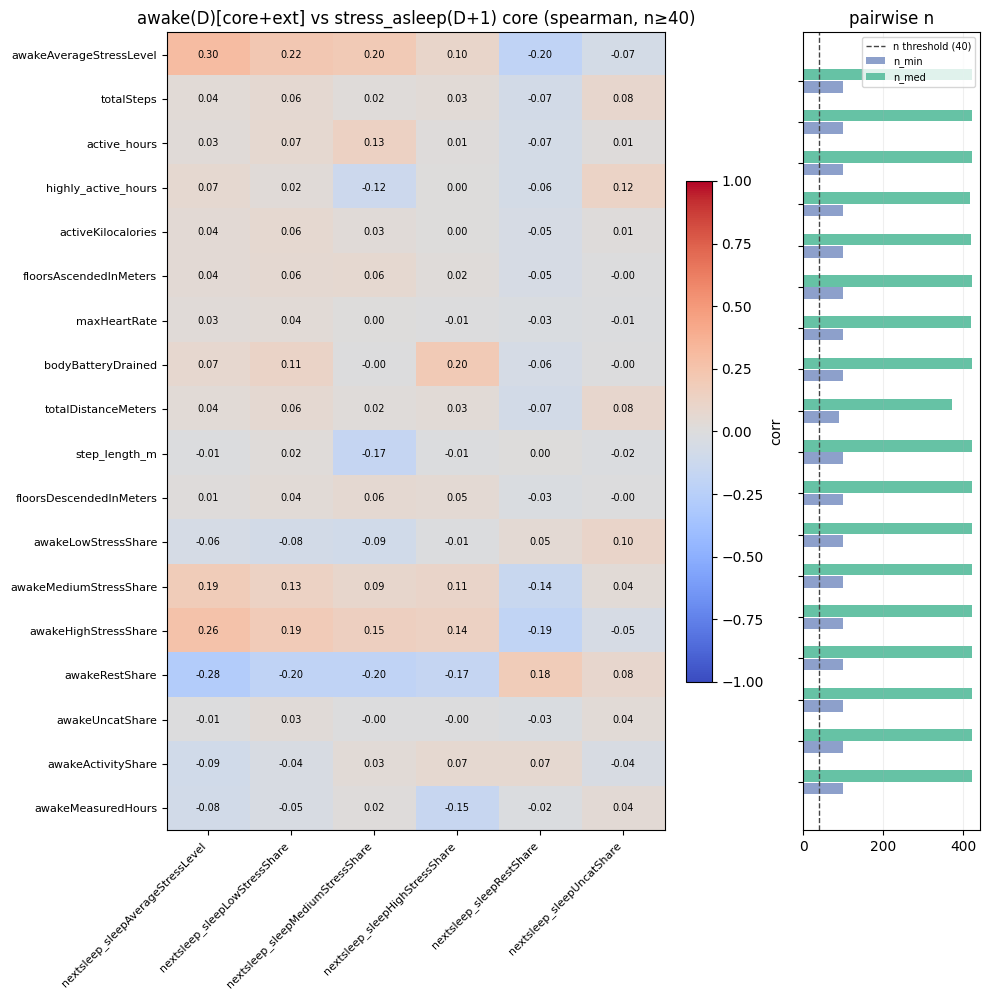

/var/folders/pz/8fjd1qc94418j8z0tl50g2yw0000gn/T/ipykernel_8724/3274604494.py:238: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  base_cmap = plt.cm.get_cmap('coolwarm')


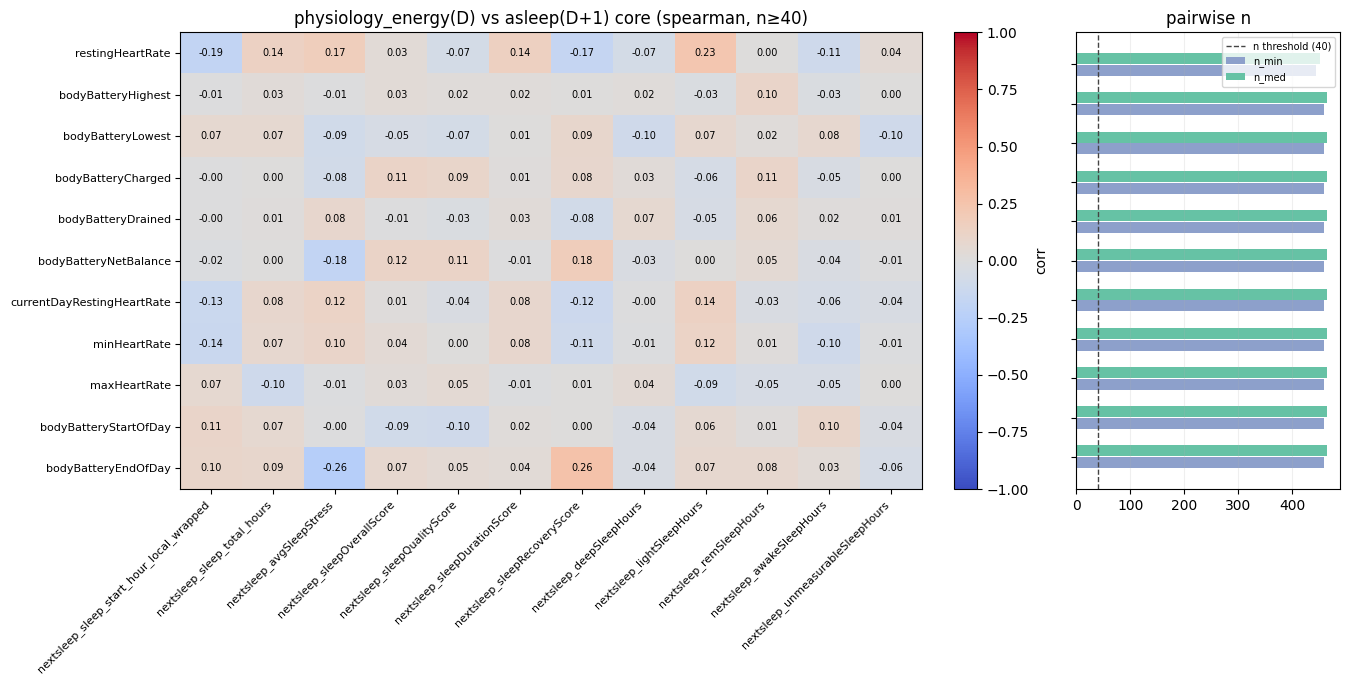

/var/folders/pz/8fjd1qc94418j8z0tl50g2yw0000gn/T/ipykernel_8724/3274604494.py:238: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  base_cmap = plt.cm.get_cmap('coolwarm')


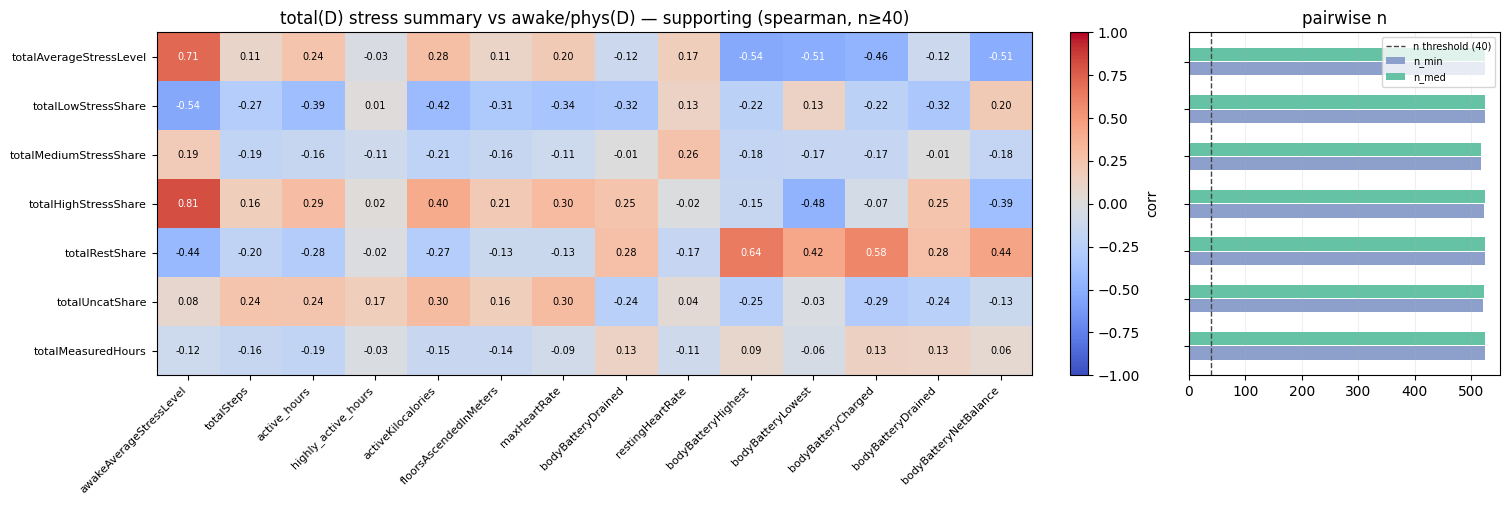

ValueError: dropna must be unspecified as the new implementation does not introduce rows of NA values. This argument will be removed in a future version of pandas.

In [20]:
# Correlation matrix feature groups (curated, grouped, core vs extended)
corr_groups = {
    'asleep_core_D': [
        # core timing + quantity + scores
        'sleep_start_hour_local_wrapped',
        'sleep_total_hours',
        # all main sleep scores together
        'sleepOverallScore',
        'sleepQualityScore',
        'sleepDurationScore',
        'sleepRecoveryScore',
        # all main sleep stage hours together
        'deepSleepHours',
        'lightSleepHours',
        'remSleepHours',
        'awakeSleepHours',
        'unmeasurableSleepHours',
    ],
    'asleep_extended_D': [
        'sleepRespirationAverage',
        'sleepRespirationLowest',
        'sleepRespirationHighest',
        'sleepSpo2Average',
        'sleepSpo2Lowest',
        'sleepSpo2AverageHR',
    ],
    'stress_asleep_core_D': [
        'sleepAverageStressLevel',
        'sleepLowStressShare',
        'sleepMediumStressShare',
        'sleepHighStressShare',
        'sleepRestShare',
        'sleepUncatShare',
    ],
    'stress_asleep_extended_D': [
        'sleepMeasuredHours',
        'sleepActivityHours',
        'sleepLowStressHours',
        'sleepMediumStressHours',
        'sleepHighStressHours',
        'sleepRestHours',
        'sleepUncatHours',
    ],
    'awake_core_D': [
        'awakeAverageStressLevel',
        'totalSteps',
        'active_hours',
        'highly_active_hours',
        'activeKilocalories',
        'floorsAscendedInMeters',
        'maxHeartRate',
        'bodyBatteryDrained',
    ],
    'awake_extended_D': [
        'totalDistanceMeters',
        'step_length_m',
        'floorsDescendedInMeters',
        'awakeLowStressShare',
        'awakeMediumStressShare',
        'awakeHighStressShare',
        'awakeRestShare',
        'awakeUncatShare',
        'awakeActivityShare',
        'awakeMeasuredHours',
    ],
    'physiology_energy_core_D': [
        'restingHeartRate',
        'bodyBatteryHighest',
        'bodyBatteryLowest',
        'bodyBatteryCharged',
        'bodyBatteryDrained',
        'bodyBatteryNetBalance',
    ],
    'physiology_energy_extended_D': [
        'currentDayRestingHeartRate',
        'minHeartRate',
        'maxHeartRate',
        'bodyBatteryStartOfDay',
        'bodyBatteryEndOfDay',
    ],
    'stress_total_extended_D': [
        'totalAverageStressLevel',
        'totalLowStressShare',
        'totalMediumStressShare',
        'totalHighStressShare',
        'totalRestShare',
        'totalUncatShare',
        'totalMeasuredHours',
    ],
}


# Show a compact registry/availability table for the matrix feature groups.
registry_rows = []
for group_name, cols in corr_groups.items():
    if group_name.startswith(('asleep_', 'stress_asleep_')):
        frame_name, frame_ref = 'df_sleep_e', df_sleep_e
    elif group_name.startswith(('awake_', 'physiology_energy_', 'stress_total_')):
        frame_name, frame_ref = 'df_strict_e', df_strict_e
    else:
        frame_name, frame_ref = 'unknown', df_strict_e
    for col in cols:
        registry_rows.append({
            'group': group_name,
            'frame': frame_name,
            'metric': col,
            'present': col in frame_ref.columns,
        })
corr_registry = pd.DataFrame(registry_rows)
_safe_display_any(
    corr_registry.groupby(['group', 'frame'], as_index=False).agg(n_metrics=('metric', 'count'), n_present=('present', 'sum'))
)

# Prefix helper for next-sleep matrix columns.
def _prefixed_existing(frame: pd.DataFrame, cols: list[str], prefix: str) -> list[str]:
    out = []
    for c in cols:
        pc = f'{prefix}{c}'
        if pc in frame.columns:
            out.append(pc)
    return out

asleep_core_D = corr_groups['asleep_core_D']
asleep_ext_D = corr_groups['asleep_extended_D']
asleep_stress_core_D = corr_groups['stress_asleep_core_D']
asleep_stress_ext_D = corr_groups['stress_asleep_extended_D']
awake_core_D = corr_groups['awake_core_D']
awake_ext_D = corr_groups['awake_extended_D']
phys_core_D = corr_groups['physiology_energy_core_D']
phys_ext_D = corr_groups['physiology_energy_extended_D']
stress_total_ext_D = corr_groups['stress_total_extended_D']

asleep_core_Dp1 = _prefixed_existing(df_day_nextsleep, asleep_core_D, 'nextsleep_')
asleep_ext_Dp1 = _prefixed_existing(df_day_nextsleep, asleep_ext_D, 'nextsleep_')
asleep_stress_core_Dp1 = _prefixed_existing(df_day_nextsleep, asleep_stress_core_D, 'nextsleep_')

# Core matrix set (readable baseline)
plot_corr_block(df_sleep_e, asleep_core_D, asleep_core_D, title='asleep(D) vs asleep(D) — core', method='spearman', fig_name='corr_asleepD_asleepD_core')
plot_corr_block(df_strict_e, awake_core_D, awake_core_D, title='awake(D) vs awake(D) — core', method='spearman', fig_name='corr_awakeD_awakeD_core')
plot_corr_block(df_sleep_e, asleep_core_D, awake_core_D, title='asleep(D) vs awake(D) — core', method='spearman', fig_name='corr_asleepD_awakeD_core')
plot_corr_block(df_day_nextsleep, awake_core_D, asleep_core_Dp1, title='awake(D) vs asleep(D+1) — core', method='spearman', fig_name='corr_awakeD_asleepDplus1_core')

# Expanded matrix set (grouped, still readable by submatrix)
plot_corr_block(df_sleep_e, asleep_stress_core_D, asleep_core_D, title='stress_asleep(D) vs asleep(D) — core stress', method='spearman', fig_name='corr_stress_asleepD_to_asleepD_core')
plot_corr_block(df_sleep_e, asleep_stress_ext_D, asleep_core_D, title='stress_asleep(D) durations vs asleep(D) — extended', method='spearman', fig_name='corr_stress_asleepD_to_asleepD_ext')
plot_corr_block(df_strict_e, phys_core_D, awake_core_D, title='physiology_energy(D) vs awake(D) — core', method='spearman', fig_name='corr_physD_awakeD_core')
plot_corr_block(df_sleep_e, asleep_core_D, phys_core_D, title='asleep(D) vs physiology_energy(D) — core', method='spearman', fig_name='corr_asleepD_physD_core')
plot_corr_block(df_day_nextsleep, awake_core_D + awake_ext_D, asleep_core_Dp1, title='awake(D)[core+ext] vs asleep(D+1) core', method='spearman', fig_name='corr_awakeD_ext_to_asleepDplus1_core')
plot_corr_block(df_strict_e, awake_core_D + awake_ext_D, awake_core_D + awake_ext_D, title='awake(D) vs awake(D) — core+extended', method='spearman', fig_name='corr_awakeD_awakeD_core_ext')
plot_corr_block(df_sleep_e, asleep_core_D, awake_core_D + awake_ext_D, title='asleep(D) vs awake(D)[core+ext]', method='spearman', fig_name='corr_asleepD_awakeD_core_ext')
plot_corr_block(df_day_nextsleep, awake_core_D + awake_ext_D, asleep_stress_core_Dp1, title='awake(D)[core+ext] vs stress_asleep(D+1) core', method='spearman', fig_name='corr_awakeD_ext_to_stress_asleepDplus1_core')
plot_corr_block(df_day_nextsleep, phys_core_D + phys_ext_D, asleep_core_Dp1, title='physiology_energy(D) vs asleep(D+1) core', method='spearman', fig_name='corr_physD_to_asleepDplus1_core')

# Optional supporting matrix: total stress summary vs core awake/sleep (useful to inspect but lower priority for directionality)
plot_corr_block(df_strict_e, stress_total_ext_D, awake_core_D + phys_core_D, title='total(D) stress summary vs awake/phys(D) — supporting', method='spearman', fig_name='corr_totalD_supporting')



def _top_abs_pairs_from_blocks(
    frame: pd.DataFrame,
    row_cols: list[str],
    col_cols: list[str],
    *,
    method: str = 'spearman',
    min_n: int = 80,
    min_abs_corr: float = 0.15,
    top_k: int = 12,
) -> pd.DataFrame:
    corr, nobs = _pairwise_corr_block(frame, row_cols, col_cols, method=method)
    if corr.empty:
        return pd.DataFrame()

    long = corr.stack().rename('corr').reset_index()
    long.columns = ['row_metric', 'col_metric', 'corr']
    long = long.dropna(subset=['corr'])
    long['n'] = long.apply(lambda r: float(nobs.loc[r['row_metric'], r['col_metric']]), axis=1)
    long['abs_corr'] = long['corr'].abs()

    # If symmetric same-set block, keep only one triangle to avoid duplicate pairs.
    if row_cols == col_cols:
        pos = {c: i for i, c in enumerate(corr.index)}
        long = long[long.apply(lambda r: pos.get(r['row_metric'], -1) < pos.get(r['col_metric'], -1), axis=1)]

    long = long[(long['n'] >= min_n) & (long['abs_corr'] >= min_abs_corr)]
    long = long.sort_values(['abs_corr', 'n'], ascending=[False, False]).head(top_k)
    return long.reset_index(drop=True)


# Shortlist strongest day->next-night pairs from the expanded awake set.
shortlist_day_to_nextsleep = _top_abs_pairs_from_blocks(
    df_day_nextsleep,
    awake_core_D + awake_ext_D,
    asleep_core_Dp1 + asleep_stress_core_Dp1,
    method='spearman',
    min_n=80,
    min_abs_corr=0.15,
    top_k=12,
)

if shortlist_day_to_nextsleep.empty:
    print('No day->next-night pairs passed shortlist thresholds.')
else:
    _safe_display_any(shortlist_day_to_nextsleep)

    # Plot a compact subset for visual sanity-check of top ranked associations.
    for i, r in shortlist_day_to_nextsleep.head(4).iterrows():
        xcol = str(r['row_metric'])
        ycol = str(r['col_metric'])
        plot_relationship(
            df_day_nextsleep,
            xcol,
            ycol,
            title=f'Top day→next-night pair #{i+1}: {xcol} vs {ycol}',
            xlabel=xcol,
            ylabel=ycol,
            fig_name=f'rel_shortlist_day_to_nextsleep_{i+1:02d}',
        )





### Relationship findings (first pass, refine after visual review)

- Keep directional semantics explicit: **sleep morning context (D)**, **daytime behavior (D)**, **next-night sleep (D+1)**.
- Day-of-week segmented views include additional diagnostics: `active_hours`, `bodyBatteryNetBalance`, and sleep-onset anchored `sleep_start_hour_local` (wrapped clock handling).
- Correlation heatmaps are reliability-aware (`n` threshold mask) to reduce over-interpretation of sparse cells.
- Stress-level sentinels/out-of-range values (e.g., `-2`) are filtered to `NaN` for Block E frames before plotting.
- Use the strongest-pairs shortlist (|rho| + `n` thresholds) as the bridge from matrix screening to relationship plots.
- Consolidated observation tracker is maintained in `docs/internal/stage2_notebook03_observations.md`.
- Treat correlation and binned trends as hypothesis generation; retain causal claims only where temporal mechanism is explicit.



### 1.7 Targeted validation plots for matrix observations

This block explicitly validates selected matrix observations with direct pair plots (scatter + quantile-bin summary),
so findings are not based on heatmaps alone.


In [ ]:
targeted_validation_specs = [
    # Awake-awake checks
    (df_strict_e, 'allDayStress_AWAKE_averageStressLevel', 'active_hours', 'Awake stress vs active hours (same day)', 'awake stress', 'active_hours', 'rel_tgt_awake_stress_vs_active_hours', False, False),
    (df_strict_e, 'allDayStress_AWAKE_averageStressLevel', 'highly_active_hours', 'Awake stress vs highly active hours (same day)', 'awake stress', 'highly_active_hours', 'rel_tgt_awake_stress_vs_highly_active_hours', False, False),
    (df_strict_e, 'maxHeartRate', 'active_hours', 'Max HR vs active hours (same day)', 'maxHeartRate', 'active_hours', 'rel_tgt_max_hr_vs_active_hours', False, False),
    (df_strict_e, 'maxHeartRate', 'highly_active_hours', 'Max HR vs highly active hours (same day)', 'maxHeartRate', 'highly_active_hours', 'rel_tgt_max_hr_vs_highly_active_hours', False, False),
    (df_strict_e, 'step_length_m', 'active_hours', 'Step length vs active hours (same day)', 'step_length_m', 'active_hours', 'rel_tgt_step_length_vs_active_hours', False, False),
    (df_strict_e, 'step_length_m', 'highly_active_hours', 'Step length vs highly active hours (same day)', 'step_length_m', 'highly_active_hours', 'rel_tgt_step_length_vs_highly_active_hours', False, False),

    # Asleep-awake and asleep-internal checks
    (df_sleep_e, 'highly_active_hours', 'awakeSleepHours', 'Highly active hours vs awake-in-sleep hours (same day)', 'highly_active_hours', 'awakeSleepHours', 'rel_tgt_highly_active_vs_awake_sleep_hours', False, False),
    (df_sleep_e, 'sleep_total_hours', 'sleepHighStressShare', 'Sleep duration vs sleep high-stress share', 'sleep_total_hours', 'sleepHighStressShare', 'rel_tgt_sleep_hours_vs_sleep_high_stress_share', False, False),
    (df_sleep_e, 'sleep_total_hours', 'sleepHighStressHours', 'Sleep duration vs sleep high-stress hours', 'sleep_total_hours', 'sleepHighStressHours', 'rel_tgt_sleep_hours_vs_sleep_high_stress_hours', False, False),
    (df_sleep_e, 'sleepRestShare', 'remSleepHours', 'Sleep rest-share vs REM hours', 'sleepRestShare', 'remSleepHours', 'rel_tgt_sleep_rest_share_vs_rem_hours', False, False),
    (df_sleep_e, 'sleepRestShare', 'deepSleepHours', 'Sleep rest-share vs deep hours', 'sleepRestShare', 'deepSleepHours', 'rel_tgt_sleep_rest_share_vs_deep_hours', False, False),

    # Physiology-energy supportive check
    (df_strict_e, 'awakeAverageStressLevel', 'bodyBatteryNetBalance', 'Awake stress vs Body Battery net balance (same day)', 'awakeAverageStressLevel', 'bodyBatteryNetBalance', 'rel_tgt_awake_stress_vs_bb_net_balance', False, False),
]

for frame, xcol, ycol, title, xlabel, ylabel, fig_name, clock_axis_x, clock_axis_y in targeted_validation_specs:
    plot_relationship(
        frame,
        xcol,
        ycol,
        title=title,
        xlabel=xlabel,
        ylabel=ylabel,
        fig_name=fig_name,
        clock_axis_x=clock_axis_x,
        clock_axis_y=clock_axis_y,
    )




## 2. Block F — Artifact and anomaly review

Question: **Which suspicious days are artifacts / partial coverage vs plausible unusual days?**

Planned inputs:
- `suspicious_days.csv`
- `suspicious_days_artifacts.csv`

Planned artifact diagnostics:
- `stressTotalDurationSeconds` vs `durationInMilliseconds`
- `has_*` coverage flags
- `corrupted_stress_only_day`
- watch charging / off-wrist / no-wear interpretations


In [ ]:
artifact_input_summary = {
    'suspicious_days_rows': int(len(suspicious_days)),
    'suspicious_days_artifacts_rows': int(len(suspicious_days_artifacts)),
    'suspicious_days_cols_preview': list(suspicious_days.columns[:12]),
    'suspicious_days_artifacts_cols_preview': list(suspicious_days_artifacts.columns[:12]),
}
artifact_input_summary


### Artifact review findings (placeholder)

- Fill after building artifact taxonomy + day-card examples.


## 3. Block G — Findings, hypotheses, limitations

Question: **What did Stage 2 establish, what hypotheses follow, and what are the limits?**

This final section should close the notebook (not leave it as a plot dump).

Planned subsections:
- Findings (8-12 concise bullets)
- Hypotheses for next step (4-8)
- Limitations (N=1, wearable/model metrics, coverage gaps, observational EDA)


### Findings (current synthesis from Blocks D/E + matrix screening)

- `awake stress (D) -> asleep stress (D+1)` is one of the most stable directional signals; it appears in both relationship plots and grouped correlations.
- `sleep_total_hours -> sleepOverallScore` is clearly nonlinear: both too-short and too-long nights underperform the mid-range duration band.
- Sleep-start timing (local) shows weak direct association with sleep quality after wrapped-time correction; timing alone is not a strong predictor.
- Within sleep composition, higher sleep stress aligns with lower REM/deep share and higher awake-in-sleep share.
- In awake-day metrics, steps and active hours move together strongly; this supports walking-driven activity interpretation.
- `highly_active_hours` behaves differently from moderate activity: it is more often linked to worse next-night REM/fragmentation proxies.
- Daytime stress composition matters: higher `awakeHighStressShare` tends to reduce next-night recovery, while higher `awakeRestShare` tends to improve it.
- Body Battery net/drain metrics align with stress burden as expected, but interpretation remains descriptive (model-derived metric).

### Hypotheses (to carry into next iteration)

- Stress inertia hypothesis: elevated daytime stress propagates into night stress and lower overnight recovery.
- Recovery tradeoff hypothesis: very high-intensity daytime load can improve fatigue but worsen sleep architecture (REM/awakenings).
- Sleep-duration optimum hypothesis: there is an individual optimum band for `sleepOverallScore`, not a monotonic "more is better" relation.
- Rest-share buffer hypothesis: daytime low-stress/rest share acts as a protective factor for next-night recovery metrics.
- Timing confounding hypothesis: bedtime effects are secondary to stress/activity composition and should be analyzed with controls.

### Limitations

- Single-subject observational data (`N=1`), no causal identification.
- Wearable/model-dependent metrics (sleep scores, stress, Body Battery) are proxies, not clinical ground truth.
- Coverage gaps and charging/off-wrist artifacts can bias daily aggregates despite quality filters.
- Circular-time variables (sleep start) require wrapped handling; linear correlation remains imperfect for periodic signals.
- Multiple comparisons risk: matrix screening can surface spurious associations without holdout/robustness checks.

